In [2]:
import json
import tkp.db
import tkp.config
import logging
import csv
import datetime
import os
import glob

import numpy as np
import pandas as pd
import scipy as sp
import healpy as hp
from scipy.interpolate import griddata
import astropy
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, match_coordinates_sky,  AltAz, EarthLocation
from astropy.io import fits
from astropy.wcs import WCS

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 0.5:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def cart2pol(x, y):
    """
     Cartesian to Polar coordinate conversion, for distance measure around celestial pole.
    """
    r = np.sqrt( x**2. + y**2 )
    theta = np.arctan(y/x )
    
    if (y >= 0) and (x >= 0):
        return r, theta 
    elif ((y > 0) and (x < 0)) or ((y < 0) and (x < 0)):
        return r, theta+np.pi
    elif ((y < 0) and (x > 0)):
        return r, theta+(2*np.pi)

def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    return transients

def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr.iloc[i].decl),
                np.deg2rad(sr.iloc[i].ra))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr.iloc[i].f_int))
            x.append(float(flux))
            w.append(float(sr.iloc[i].f_int_err))
        else:
            continue

    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1], x, y, cat_indexes


In [4]:
def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def cart2pol(x, y):
    """
     Cartesian to Polar coordinate conversion, for distance measure around celestial pole.
    """
    r = np.sqrt( x**2. + y**2 )
    theta = np.arctan(y/x )
    
    if (y >= 0) and (x >= 0):
        return r, theta 
    elif ((y > 0) and (x < 0)) or ((y < 0) and (x < 0)):
        return r, theta+np.pi
    elif ((y < 0) and (x > 0)):
        return r, theta+(2*np.pi)

def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    return transients

def distSquared(p0, p1, r=0.5):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < r:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

In [5]:
# import database username/password/etc.
import sys
sys.path.append('/home/kuiack')
from database_info import *
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING

dataset = 1

logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

In [131]:
dbname = "ASr_201611140501"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

# print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """
    SELECT datname from pg_database
    """

databases = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

AS_databases = [x for x in databases.datname if (x[:3] == "ASf" or x[:3] == "ASr")]

db._configured = False
del db, session

print len(AS_databases)

89


In [132]:

delta = datetime.timedelta()

db_len = [] 
db_start = []

for AS_db in AS_databases:
    
    dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

#     print "database name: ",  AS_db
    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    transients_query = """
        SELECT taustart_ts FROM image
        """

    times = pd.DataFrame(run_query(transients_query, AS_db, dataset, engine, host, port, user, password))
#     roundtime = [i for i in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))]
    try: 
        obs_len = datetime.timedelta(seconds=len(np.unique(times.taustart_ts.dt.round("1s"))))
        db_len.append(obs_len.total_seconds())
        db_start.append(np.min(np.unique(times.taustart_ts.dt.round("1s"))))
        delta += obs_len
        db._configured = False
        del db, session
        
    except AttributeError:
        print AS_db
        db_len.append(0)
        db_start.append(0)
        db._configured = False
        del db, session

#     print "\t", obs_len



ASf_201905290920


In [133]:
print "Total currently archived", delta.total_seconds()/60./60.

Total currently archived 587.960277778


In [134]:
survey_stats  = pd.DataFrame({"db_name":AS_databases, 
              "db_len":db_len,
              "db_start":db_start})

In [26]:
AS_databases

[u'ASr_201809230412',
 u'ASr_201809280900',
 u'ASr_201809281701',
 u'ASr_201809290600',
 u'ASr_20181027',
 u'ASr_201609051647',
 u'ASr_201609070340',
 u'ASr_201611120632',
 u'ASr_201611132000',
 u'ASr_201611140501',
 u'ASr_201702241630',
 u'ASr_201702250130',
 u'ASr_201702250800',
 u'ASr_201702251405',
 u'ASr_201702260116',
 u'ASr_201702260800',
 u'ASr_201702261405',
 u'ASr_201702270350',
 u'ASr_201702280900',
 u'ASr_201809220111',
 u'ASr_201809220609',
 u'ASr_201809221701',
 u'ASr_201810162000',
 u'ASr_201810170300',
 u'ASr_201810210800',
 u'ASr_201810211605',
 u'ASr_20181024',
 u'ASr_20181025',
 u'ASr_20181026',
 u'ASr_20181029',
 u'ASr_20181101',
 u'ASf_20181103',
 u'ASf_20181104',
 u'ASr_20181102',
 u'ASf_20181105',
 u'ASf_20190101',
 u'ASf_20181231',
 u'ASf_20190113',
 u'ASf_20190120',
 u'ASf_20190119',
 u'ASf_20190118',
 u'ASr_20181028',
 u'ASf_20190117',
 u'ASf_20190110',
 u'ASf_20190129',
 u'ASf_20190126',
 u'ASf_201804281040',
 u'ASf_20190106',
 u'ASf_20190109',
 u'ASf_2019011

In [ ]:


aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
ateam = pd.DataFrame({"ra":np.array([82.88,299.43,350.28,187.07]), 
                      "decl":np.array([21.98,40.59,58.54,12.66])})

CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')




def process_timeinterval(frame, dbname):
    
#     if os.path.exists("/data/strip/{}/{}_{}.png".format(dbname, dbname, str(frame).zfill(3))):
#         return 0
    
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()
    

#     transients_query = '''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band, im.taustart_ts 
#                 FROM extractedsource ex, assocxtrsource ax, image im  
#                 WHERE im.taustart_ts BETWEEN '%s' AND '%s'  AND im.band = 23
#                 AND ax.xtrsrc = ex.id AND ex.image = im.id;'''% (times[frame], times[frame+1])
    
    transients_query = '''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.freq_eff, im.taustart_ts 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '%s' AND '%s'  AND ex.extract_type = 0 
                AND ax.xtrsrc = ex.id AND ex.image = im.id;'''% (times[frame], times[frame+1])
    

    light_curves = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))


    db._configured = False
    del db, session
    
    try:
        lc_index = light_curves.groupby("runcat").size() > 5
    except KeyError:
        return 0
        

    tot_df = pd.DataFrame({"ra":[],"decl":[], "f_avg":[],"f_std":[]})

    for i in lc_index.index:
        if not lc_index.loc[i]:
            continue
            
        light_curve = light_curves[light_curves.runcat == i]
        
#         sr_x, sr_y = pol2cart(np.abs(90-light_curve.decl.mean()),
#                 np.deg2rad(light_curve.ra.mean()))

#         cat_x, cat_y = pol2cart(np.abs(90-aart.decl),
#                 np.deg2rad(aart.ra))

#         index = distSquared((sr_x,sr_y),
#                    np.array([cat_x, cat_y]))
        
#         if type(index) == np.ndarray:
#             continue 
            
        cat_x, cat_y = pol2cart(np.abs(90-ateam.decl),
                np.deg2rad(ateam.ra))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]), r=5.0)
        
        if type(index) == np.ndarray:
            continue 
        
        
        sun_pos = pd.DataFrame({"ra":[astropy.coordinates.get_sun(astropy.time.Time((times[1]-times[0])/2.+times[0])).ra.deg],
                   "decl":[astropy.coordinates.get_sun(astropy.time.Time((times[1]-times[0])/2.+times[0])).dec.deg]})
        
        cat_x, cat_y = pol2cart(np.abs(90-sun_pos.decl),
                np.deg2rad(sun_pos.ra))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]), r=5.0)
        
        if type(index) == np.ndarray:
            continue 
        

        light_curve["flux"] = light_curve.f_int
        light_curve["time"] = light_curve.taustart_ts

        reg_time = pd.date_range(start=np.min(pd.to_datetime(light_curve.taustart_ts)), 
                         end=np.max(pd.to_datetime(light_curve.taustart_ts)), freq="1s")
        
        reg_df = pd.DataFrame({"flux":np.zeros(len(reg_time)),"time":reg_time })
        reg_flux = pd.concat([reg_df,light_curve ]).groupby("time").max().flux.fillna(0)


        n_scint = count_scintels(i, light_curves)

        for i in range(n_scint):
            tot_df = tot_df.append({"ra":light_curve.ra.mean(),
                                    "decl":light_curve.decl.mean(),
                                    "f_avg":reg_flux.mean(),
                                    "f_std":reg_flux.std()},
                                   ignore_index=True)


    if len(tot_df.ra) == 0:
        return 1
    
    list_ra = [x*u.degree for x in tot_df.ra]
    list_decl = [x*u.degree for x in tot_df.decl]

    
    position = SkyCoord(list_ra, list_decl)


    obs_times = [times[int(frame)]] 

    altaz = position.transform_to(AltAz(obstime=obs_times*len(list_ra), location=CS002))
    AART_altaz = SkyCoord(aart.ra.values*u.deg, 
                          aart.decl.values*u.deg).transform_to(AltAz(obstime=obs_times*len(aart.ra),
                                                                 location=CS002))

    ecliptic = SkyCoord(np.concatenate([np.linspace(-180,180,360),
                               np.linspace(-180,180,360),
                               np.linspace(-180,180,360),
                               np.linspace(-180,180,360),
                                       180*np.ones(180),
                                       0*np.ones(180),
                                       90*np.ones(180),
                                       270*np.ones(180)]), 
                    np.concatenate([np.zeros(360),
                               20*np.ones(360),
                               40*np.ones(360),
                               60*np.ones(360),
                                np.linspace(-90,90,180),
                                   np.linspace(-90,90,180),
                                   np.linspace(-90,90,180),
                                   np.linspace(-90,90,180)]), 
                    unit="deg", 
                    frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*(4*360+4*180), location=CS002))

    text_ecliptic = SkyCoord([180,180,180,180],[0,20,40,60],unit="deg", 
                             frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*4, location=CS002))
    
    Galactic = SkyCoord(np.linspace(0,360,360), np.zeros(360), 
                    unit="deg", frame="galactic" ).transform_to(AltAz(obstime=obs_times*(360), location=CS002))
  
    
    sun_op_lon = (SkyCoord(sun_pos.ra.values, sun_pos.decl.values, 
             unit="deg",frame="fk5").transform_to('barycentrictrueecliptic').lon.deg-180. ) % 360

    sun_opposition = SkyCoord(sun_op_lon*np.ones(100), 
                              np.linspace(0,90,100), unit="deg",
                              frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*(100), 
                                                                                  location=CS002))


    
    
    text_ecliptic_x = -pol2cart((90-text_ecliptic.alt.deg), text_ecliptic.az.rad,)[1]
    text_ecliptic_y = pol2cart((90-text_ecliptic.alt.deg), text_ecliptic.az.rad,)[0]
    
    AltAz_x = -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]
    AltAz_y = pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0]
    
    aart_x = -pol2cart((90-AART_altaz.alt.deg), AART_altaz.az.rad,)[1]
    aart_y = pol2cart((90-AART_altaz.alt.deg), AART_altaz.az.rad,)[0]

    ecliptic_x = -pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[1]
    ecliptic_y = pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[0]
    
    Galactic_x = -pol2cart((90-Galactic.alt.deg), Galactic.az.rad,)[1]
    Galactic_y = pol2cart((90-Galactic.alt.deg), Galactic.az.rad,)[0]

    sun_opposition_x = -pol2cart((90-sun_opposition.alt.deg), sun_opposition.az.rad,)[1]
    sun_opposition_y = pol2cart((90-sun_opposition.alt.deg), sun_opposition.az.rad,)[0]
 
  
    
    AltAz_x, AltAz_y = AltAz_x[(np.sqrt(AltAz_x**2. + AltAz_y**2.) < 55)], AltAz_y[(np.sqrt(AltAz_x**2. + AltAz_y**2.) < 55)]
    aart_x, aart_y = aart_x[(np.sqrt(aart_x**2. + aart_y**2.) < 55)], aart_y[(np.sqrt(aart_x**2. + aart_y**2.) < 55)]
    ecliptic_x, ecliptic_y = ecliptic_x[(np.sqrt(ecliptic_x**2. + ecliptic_y**2.) < 55)], ecliptic_y[(np.sqrt(ecliptic_x**2. + ecliptic_y**2.) < 55)]  
    Galactic_x, Galactic_y = Galactic_x[(np.sqrt(Galactic_x**2. + Galactic_y**2.) < 55)], Galactic_y[(np.sqrt(Galactic_x**2. + Galactic_y**2.) < 55)]  
    sun_opposition_x, sun_opposition_y = sun_opposition_x[(np.sqrt(sun_opposition_x**2. + sun_opposition_y**2.) < 55)], sun_opposition_y[(np.sqrt(sun_opposition_x**2. + sun_opposition_y**2.) < 55)]  

    
    xmin, xmax = -55, 55
    ymin, ymax = -55, 55

    
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([AltAz_x, AltAz_y])
    kernel = st.gaussian_kde(values, bw_method=0.35 )
    f = np.reshape(len(values[0])*kernel(positions).T, xx.shape)

    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    ax.plot(AltAz_x, AltAz_y, ".", c="k", label="Transient")

    ax.scatter(ecliptic_x, ecliptic_y,
               c="grey", s=0.2, label=None)

    ax.scatter(Galactic_x, Galactic_y,
               c="red", s=0.2, label=None)

    ax.scatter(aart_x, aart_y, marker="o",
               c="orange", s=50, label="AARTFAAC source", zorder=5)

    ax.plot(sun_opposition_x, sun_opposition_y, "--",
               c="green", label="Solar opposition")


    ax.plot(-pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[1],
            pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[0],"r")


    for t_x, t_y, t_s in zip(text_ecliptic_x,text_ecliptic_y,['0','20','40','60']) :
        if (np.sqrt(t_x**2. + t_y**2.) > 55):
            continue 
        ax.text(t_x, t_y, t_s, zorder=5)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


    levels = [1e-1, 1.5e-1, 2e-1, 2.5e-1,3e-1, 3.5e-1,4e-1, 4.5e-1, 5.0e-1, 5.5e-1 ]

    # Contourf plot
    cfset = ax.contourf(xx, yy, f, levels, cmap='Blues', label="Source KDE")

    # Contour plot
    cset = ax.contour(xx, yy, f, levels, colors='grey', label="Source KDE")

    # Label plot
    plt.title(str(times[int(frame)].date())+":\n "
              +str(times[int(frame)].time())+" to "
              +str(str(times[int(frame)+1].time()))+" [UTC]"
              ,y=-0.025, va="top")


    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=2)
    plt.annotate("S", (0.0,0.3), xytext=(0.5,0.05), 
                 xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
    plt.annotate("N", (0.0,0.3), xytext=(0.5,0.95),  zorder=99,
                 xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   

    plt.annotate("W", (0.0,0.3), xytext=(0.95,0.5), 
                 xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
    plt.annotate("E", (0.0,0.3), xytext=(0.05,0.5), 
                 xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")    




    ax.set_xticks([])
    ax.set_yticks([])

    try: 
        r_alt, r_az =  cart2pol(np.mean(yy[f == f.max()]), 
                            np.mean(-xx[f == f.max()]))
    except TypeError:
        return 0

    strip_loc = SkyCoord( r_az*u.rad,r_alt*u.deg, frame="altaz", 
         obstime=times[int(frame)], location=CS002).transform_to("fk5")
     
    myCsvRow = [times[int(frame)], f[f > 0.5e-1].sum(), f.max(), len(f[f > 0.5e-1]),
                strip_loc.ra.deg, strip_loc.dec.deg]
    with open('/data/strip/Strip_magnitude_sub_scintcount.csv','a') as fd:
        writer = csv.writer(fd)
        writer.writerow(myCsvRow)
    
    
    
    ax.legend(loc="upper left", framealpha=1)
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.savefig("/data/strip/{}/{}_{}.png".format(dbname, dbname, str(frame).zfill(3)))
    return 0
#     plt.show()

    
####


myCsvRow = ["time", "strip_sum", "strip_max","strip_area", "ra", "decl"]

if not os.path.exists('/data/strip/Strip_magnitude_sub_scintcount.csv'):
    with open('/data/strip/Strip_magnitude_sub_scintcount.csv','a') as fd:
        writer = csv.writer(fd)
        writer.writerow(myCsvRow)


# survey_stats = pd.read_csv("/home/kuiack/AS_survey.csv")

for  dbname, start, length  in zip(survey_stats["db_name"], 
                                   survey_stats["db_start"], 
                                   survey_stats["db_len"]):
    
    times =  pd.date_range(start=start, periods=length/300., freq="300s")
    if not os.path.exists("/data/strip/{}/".format(dbname)):
        os.mkdir("/data/strip/{}/".format(dbname))
    
    print  dbname, len(times)-1
    out = Parallel(n_jobs=4)(delayed(process_timeinterval)(i, dbname) for i in range(len(times)-1))


ASr_201809230412 56


In [138]:
survey_stats

db_len           db_name                            db_start
0   17146.0  ASr_201809230412  2018-09-23T04:12:11.000000000+0000
1   24560.0  ASr_201809280900  2018-09-28T09:18:54.000000000+0000
2    8028.0  ASr_201809281701  2018-09-28T17:01:10.000000000+0000
3    7128.0  ASr_201809290600  2018-09-29T06:00:10.000000000+0000
4   28064.0      ASr_20181027  2018-10-27T07:00:10.000000000+0000
5   10728.0  ASr_201609051647  2016-09-05T13:12:11.000000000+0000
6   21342.0  ASr_201609070340  2016-09-07T03:40:10.000000000+0000
7   28207.0  ASr_201611120632  2016-11-12T06:32:12.000000000+0000
8   10323.0  ASr_201611132000  2016-11-13T20:00:11.000000000+0000
9   13982.0  ASr_201611140501  2016-11-14T05:01:11.000000000+0000
10   6488.0  ASr_201702241630  2017-02-24T16:30:10.000000000+0000
11  13073.0  ASr_201702250130  2017-02-25T01:30:10.000000000+0000
12  21425.0  ASr_201702250800  2017-02-25T08:00:10.000000000+0000
13  14862.0  ASr_201702251405  2017-02-14T16:50:20.000000000+0000
14  10669.0  ASr_201702260116  2017-02-26T01:16:10.000000000+0000
15  21434.0  ASr_201702260800  2017-02-16T12:03:14.000000000+0000
16  18437.0  ASr_201702261405  2017-02-26T11:24:23.000000000+0000
17   4403.0  ASr_201702270350  2017-02-13T12:41:37.000000000+0000
18   3512.0  ASr_201702280900  2017-02-28T09:00:10.000000000+0000
19   9527.0  ASr_201809220111  2018-09-22T01:11:10.000000000+0000
20   8327.0  ASr_201809220609  2018-09-22T06:09:11.000000000+0000
21   9949.0  ASr_201809221701  2018-09-22T17:01:10.000000000+0000
22  21530.0  ASr_201810162000  2018-10-16T20:00:10.000000000+0000
23  28728.0  ASr_201810170300  2018-10-17T03:00:10.000000000+0000
24  28730.0  ASr_201810210800  2018-10-21T08:00:10.000000000+0000
25  24530.0  ASr_201810211605  2018-10-21T16:05:10.000000000+0000
26  28074.0      ASr_20181024  2018-10-16T20:00:10.000000000+0000
27  28062.0      ASr_20181025  2018-10-25T07:00:10.000000000+0000
28  28064.0      ASr_20181026  2018-10-01T13:35:03.000000000+0000
29  22151.0      ASr_20181029  2018-10-29T07:00:21.000000000+0000
..      ...               ...                                 ...
59  19489.0  ASf_201812160230  2018-12-16T02:32:00.000000000+0000
60  34510.0  ASf_201902232216  2019-02-23T22:18:00.000000000+0000
61  49917.0      ASf_20190127  2019-01-26T13:59:27.000000000+0000
62  44260.0  ASf_201807051811  2018-06-20T16:46:41.000000000+0000
63  28430.0  ASf_201903061500  2019-03-06T15:02:00.000000000+0000
64  17690.0  ASf_201905101514  2019-05-10T15:16:00.000000000+0000
65  24844.0  ASf_201903101700  2019-03-10T17:02:00.000000000+0000
66  21272.0  ASf_201905211455  2019-05-21T14:57:00.000000000+0000
67  15012.0  ASf_201903091947  2019-03-09T19:49:00.000000000+0000
68  24853.0  ASf_201903081700  2019-03-08T17:02:00.000000000+0000
69  26437.0  ASf_201804261245  2018-04-26T12:45:10.000000000+0000
70  24854.0  ASf_201902010000  2019-02-01T00:02:00.000000000+0000
71  24853.0  ASf_201902200000  2019-02-20T00:02:00.000000000+0000
72  28350.0  ASf_201905190430  2019-05-19T04:32:00.000000000+0000
73  28427.0  ASf_201905121100  2019-05-12T11:02:00.000000000+0000
74  28408.0  ASf_201905181100  2019-05-18T11:02:00.000000000+0000
75  26544.0  ASf_201905120328  2019-05-12T03:30:00.000000000+0000
76  28386.0  ASf_201905200410  2019-05-20T04:12:00.000000000+0000
77  27825.0  ASf_201905180305  2019-05-18T03:07:00.000000000+0000
78  25666.0  ASf_201905111110  2019-05-11T11:48:22.000000000+0000
79  24523.0  ASf_201807071401  2018-07-07T14:01:15.000000000+0000
80  23285.0  ASf_201902030025  2019-02-03T00:27:00.000000000+0000
81  22468.0  ASf_201909141110  2019-09-14T11:12:00.000000000+0000
82  23959.0  ASf_201811291400  2018-11-29T14:02:00.000000000+0000
83  12613.0  ASf_201902020400  2019-02-02T04:02:00.000000000+0000
84   3783.0  ASf_201902041750  2019-02-04T17:52:00.000000000+0000
85  14124.0  ASf_201902011100  2019-02-01T11:02:00.000000000+0000
86  21264.0  ASf_201903041640  2019-03-04T16:42:00.000000000+0000
87  21041.0  ASf_201804260258  2018-04-26T02:

Text(0.5,-0.01,'2018-09-23:\n 07:17:11 to 07:22:11 [UTC]')

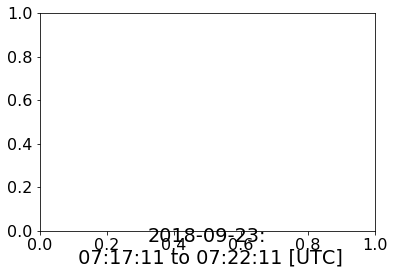

In [147]:
plt.title(str(times[int(frame)].date())+":\n "+str(times[int(frame)].time())+" to "+str(str(times[int(frame)+1].time()))+" [UTC]",y=-0.01, va="top")




In [99]:
SkyCoord(np.linspace(0,360,360), np.zeros(360), 
                    unit="deg", frame="magnetic" ).transform_to(AltAz(obstime=obs_times*(360), location=CS002))

ValueError: Coordinate frame magnetic not in allowed values ['altaz', 'barycentrictrueecliptic', 'cirs', 'fk4', 'fk4noeterms', 'fk5', 'galactic', 'galacticlsr', 'galactocentric', 'gcrs', 'geocentrictrueecliptic', 'hcrs', 'heliocentrictrueecliptic', 'icrs', 'itrs', 'lsr', 'precessedgeocentric', 'supergalactic']

In [247]:
survey_stats = pd.read_csv("/home/kuiack/AS_survey.csv")
for  dbname, start, length  in zip(survey_stats["db_name"],survey_stats["db_start"], survey_stats["db_len"]):
    print pd.date_range(start=start, periods=length/300., freq="300s")
#                       end="2019-02-01 06:45:00",  freq="300s")

DatetimeIndex(['2018-09-23 04:12:11', '2018-09-23 04:17:11',
               '2018-09-23 04:22:11', '2018-09-23 04:27:11',
               '2018-09-23 04:32:11', '2018-09-23 04:37:11',
               '2018-09-23 04:42:11', '2018-09-23 04:47:11',
               '2018-09-23 04:52:11', '2018-09-23 04:57:11',
               '2018-09-23 05:02:11', '2018-09-23 05:07:11',
               '2018-09-23 05:12:11', '2018-09-23 05:17:11',
               '2018-09-23 05:22:11', '2018-09-23 05:27:11',
               '2018-09-23 05:32:11', '2018-09-23 05:37:11',
               '2018-09-23 05:42:11', '2018-09-23 05:47:11',
               '2018-09-23 05:52:11', '2018-09-23 05:57:11',
               '2018-09-23 06:02:11', '2018-09-23 06:07:11',
               '2018-09-23 06:12:11', '2018-09-23 06:17:11',
               '2018-09-23 06:22:11', '2018-09-23 06:27:11',
               '2018-09-23 06:32:11', '2018-09-23 06:37:11',
               '2018-09-23 06:42:11', '2018-09-23 06:47:11',
               '2018-09-

In [49]:
from joblib import Parallel, delayed
import scipy.stats as st

aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
ateam = pd.DataFrame({"ra":np.array([82.88,299.43,350.28,187.07]), "decl":np.array([21.98,40.59,58.54,12.66])})

CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')



dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

# dbname = "ASr_20181027"
# times = pd.date_range(start='2018-10-27 07:00:10', 
#                       periods=92*300,  freq="300s")

# frame = 6

dbname = "ASr_201702250130"
times = pd.date_range(start='2017-02-25 01:30:00', 
                      end="2017-02-25 05:08:00",  freq="300s")
frame = 8


# dbname = "ASf_201905190430"
# times = pd.date_range(start='2018-03-09 15:30:00', 
#                       end="2018-03-10 03:45:00",  freq="300s")

# frame = 106


db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = '''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.freq_eff, im.taustart_ts 
            FROM extractedsource ex, assocxtrsource ax, image im  
            WHERE im.taustart_ts BETWEEN '%s' AND '%s'  AND ex.extract_type = 0 
            AND ax.xtrsrc = ex.id AND ex.image = im.id;'''% (times[frame], times[frame+1])

# transients_query = '''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band, im.taustart_ts 
#             FROM extractedsource ex, assocxtrsource ax, image im  
#             WHERE im.taustart_ts BETWEEN '%s' AND '%s'  AND ex.extract_type = 0 
#             AND ax.xtrsrc = ex.id AND ex.image = im.id;'''% (times[frame], times[frame+1])

light_curves = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

db._configured = False
del db, session

lc_index = light_curves.groupby("runcat").size() > 6

In [161]:
light_curves.taustart_ts.min(), light_curves.taustart_ts.max(), 

(Timestamp('2017-02-25 03:20:00'), Timestamp('2017-02-25 03:25:00'))

In [87]:
lc_index[lc_index == True].index

Int64Index([ 161,  162,  163,  164,  166,  167,  168,  169,  170,  171,
            ...
            1118, 1119, 1120, 1121, 1122, 1124, 1126, 1133, 1134, 1138],
           dtype='int64', name=u'runcat', length=268)

In [144]:
from scipy import signal
from scipy.signal import find_peaks, peak_widths

def make_mid_matches(hi_mid, low_mid):
    if len(hi_mid)*len(low_mid) == 0:
        return np.array([])
    
    out = []
    count = 0
    index = []
    # iterate shorter list to insure best 1-1 match
    if len(hi_mid) <= len(low_mid):
        for i in hi_mid:
            try:
                test = np.arange(len(low_mid))[np.logical_and(
                    np.abs(i - low_mid) == min(np.abs(i - low_mid)),
                    np.logical_and(i - low_mid >= pd.Timedelta('-120 seconds'),
                                   i - low_mid <= pd.Timedelta('20 seconds')))][0]
                out.append([i,low_mid[np.logical_and(
                    np.abs(i - low_mid) == min(np.abs(i - low_mid)),
                    np.logical_and(i - low_mid >= pd.Timedelta('-120 seconds'),
                                   i - low_mid <= pd.Timedelta('20 seconds')))][0]])
                
                index.append([count, test])

                count += 1
            except IndexError:
                count += 1
                continue
        return np.array(out, dtype='datetime64[ns]'), np.array(index)
    
    elif len(hi_mid) > len(low_mid):
        for i in low_mid:
            try:
                test = np.arange(len(hi_mid))[np.logical_and(
                    np.abs(i - hi_mid) == min(np.abs(i - hi_mid)),
                    np.logical_and(i - hi_mid >= pd.Timedelta('-120 seconds'),
                                   i - hi_mid <= pd.Timedelta('20 seconds')))][0]
                out.append([i, hi_mid[np.logical_and(
                    np.abs(i - hi_mid) == min(np.abs(i - hi_mid)),
                    np.logical_and(hi_mid - i >= pd.Timedelta('-120 seconds'),
                                   hi_mid - i <= pd.Timedelta('20 seconds')))][0]])
                
                index.append([count, test])

                count += 1
            except IndexError:
                count += 1
                continue
        # conditon 1 peak match
        try:
            return np.array(out, dtype='datetime64[ns]')[:,::-1], np.array(index)[:,::-1]
        except IndexError:
            return np.array(out, dtype='datetime64[ns]')[::-1], np.array(index)[::-1]



all_time_diff = np.array([])
all_time_out_df = pd.DataFrame([])

scintel_pos = []

_id = 162
rel_height = 0.9
skew_range = 5
kern_width = 3
kernel = np.ones(kern_width)

for _id in lc_index[lc_index == True].index:
    source_df = light_curves[light_curves.runcat == _id]
    source_df.taustart_ts = pd.to_datetime(source_df.taustart_ts)



    try:
        hi_source_flux = source_df.f_int[(source_df.freq_eff > 60000000) ].values
        hi_source_time = source_df.taustart_ts[(source_df.freq_eff > 60000000)].values

        hi_raw_df = pd.DataFrame({"flux":hi_source_flux, "time":hi_source_time}) 

        hi_reg_time = pd.date_range(start=np.min(hi_source_time-pd.Timedelta('1 seconds')), 
                                 end=np.max(hi_source_time+pd.Timedelta('1 seconds')), freq="1s")
        hi_reg_df = pd.DataFrame({"reg_flux":np.zeros(len(hi_reg_time)),"time":hi_reg_time })
        hi_reg_flux = pd.concat([hi_reg_df,hi_raw_df]).groupby("time").max().flux.fillna(0)

        hi_smoothed = signal.filtfilt(kernel,np.sum(kernel) ,hi_reg_flux, method="pad")


        low_source_flux = source_df.f_int[(source_df.freq_eff < 60000000) ].values
        low_source_time = source_df.taustart_ts[(source_df.freq_eff < 60000000)].values

        low_raw_df = pd.DataFrame({"flux":low_source_flux, "time":low_source_time}) 
        low_reg_time = pd.date_range(start=np.min(low_source_time-pd.Timedelta('1 seconds')), 
                                 end=np.max(low_source_time+pd.Timedelta('1 seconds')), freq="1s")
        low_reg_df = pd.DataFrame({"reg_flux":np.zeros(len(low_reg_time)),"time":low_reg_time })
        low_reg_flux = pd.concat([low_reg_df, low_raw_df]).groupby("time").max().flux.fillna(0)

        low_smoothed = signal.filtfilt(kernel,np.sum(kernel) ,low_reg_flux, method="pad")


        min_width = 5
        max_width = None

        # if _db[:3] == "ASr":
        min_prominence = 5
        # elif _db[:3] == "ASf":
        #     min_prominence = 30

        hi_peaks, hi_properties = signal.find_peaks(hi_smoothed, 
                                                prominence=[min_prominence,None], 
                                                width=[min_width ,max_width],
                                                rel_height=0.5)
        hi_results_full = peak_widths(hi_smoothed, hi_peaks, rel_height=rel_height)
        #     hi_results_full[0]  # widths

        low_peaks, low_properties = signal.find_peaks(low_smoothed, 
                                                      prominence=[min_prominence,None], 
                                                      width=[min_width ,max_width], 
                                                      rel_height=0.5)
        low_results_full = peak_widths(low_smoothed, low_peaks, rel_height=rel_height)
        #     low_results_full[0]  # widths


        hi_mid_time = hi_reg_time[np.array(hi_results_full[2], dtype="int")]+\
                   (hi_reg_time[np.array(hi_results_full[3], dtype="int")]-\
                   hi_reg_time[np.array(hi_results_full[2], dtype="int")])/2.

        low_mid_time = low_reg_time[np.array(low_results_full[2], dtype="int")]+\
                   (low_reg_time[np.array(low_results_full[3], dtype="int")]-\
                   low_reg_time[np.array(low_results_full[2], dtype="int")])/2.

        # match times

        time_out, time_ind_out = make_mid_matches(hi_mid_time, low_mid_time)

        # sort to later remove one-to-many matches 
        
        dif_arrange = np.argsort(np.abs(pd.to_datetime(time_out[:,0])- pd.to_datetime(time_out[:,1])))


        time_out_df = pd.DataFrame({"ID":_id*np.ones(len(dif_arrange)),
        #                             "vlssr":vlssr_flux.values*np.ones(len(dif_arrange)),
                                    "hi_time":time_out[:,0][dif_arrange],
                                    "low_time":time_out[:,1][dif_arrange],
                                    "hi_ind":time_ind_out[:,0][dif_arrange],
                                    "hi_flux":hi_reg_flux[hi_peaks[time_ind_out[:,0][dif_arrange]]].values,
                                    "hi_width":hi_results_full[0][time_ind_out[:,0][dif_arrange]],
                                    "low_ind":time_ind_out[:,1][dif_arrange],
                                    "low_flux":low_reg_flux[low_peaks[time_ind_out[:,1][dif_arrange]]].values,
                                    "low_width":low_results_full[0][time_ind_out[:,1][dif_arrange]],
                                    "time_dif":np.abs(pd.to_datetime(time_out[:,0])- pd.to_datetime(time_out[:,1]))[dif_arrange], 
                                    "natime_diff":(pd.to_datetime(time_out[:,0])- pd.to_datetime(time_out[:,1]))[dif_arrange].total_seconds()})


        # drop longer interval of one-to-many match
        time_out_df  = time_out_df.drop(time_out_df[np.logical_or(time_out_df.hi_time.duplicated(keep="first"),
                             time_out_df.low_time.duplicated(keep="first"))].index)

        # drop highly asymmetric pulses 
#         all_time_diff = np.append(all_time_diff, time_out_df[np.logical_and((np.abs((pd.to_datetime(low_mid_time)[time_out_df.low_ind] - \
#                                   pd.to_datetime(low_reg_time[low_peaks[time_out_df.low_ind]])).total_seconds()) <= skew_range),
#                   (np.abs((pd.to_datetime(hi_mid_time)[time_out_df.hi_ind] - \
#                                   pd.to_datetime(hi_reg_time[hi_peaks[time_out_df.hi_ind]])).total_seconds()) <= skew_range))].natime_diff.values)
        out_put = time_out_df[np.logical_and((np.abs((pd.to_datetime(low_mid_time)[time_out_df.low_ind] - \
                                                       pd.to_datetime(low_reg_time[low_peaks[time_out_df.low_ind]])).total_seconds()) <= skew_range),
                                              (np.abs((pd.to_datetime(hi_mid_time)[time_out_df.hi_ind] - \
                                                       pd.to_datetime(hi_reg_time[hi_peaks[time_out_df.hi_ind]])).total_seconds()) <= skew_range))]
        
    except ValueError:
        continue 
    except IndexError:
        continue 
        
    print len(out_put), _id
    scintel_pos.append([len(out_put), 
                        light_curves[light_curves.runcat == _id].ra.mean(), 
                        light_curves[light_curves.runcat == _id].decl.mean()])
# if len(all_time_out_df) == 0:
#     all_time_out_df = time_out_df[np.logical_and((np.abs((pd.to_datetime(low_mid_time)[time_out_df.low_ind] - \
#                               pd.to_datetime(low_reg_time[low_peaks[time_out_df.low_ind]])).total_seconds()) <= skew_range),
#               (np.abs((pd.to_datetime(hi_mid_time)[time_out_df.hi_ind] - \
#                               pd.to_datetime(hi_reg_time[hi_peaks[time_out_df.hi_ind]])).total_seconds()) <= skew_range))]
# elif len(all_time_out_df) > 0:
#     all_time_out_df = pd.concat([all_time_out_df,time_out_df[np.logical_and((np.abs((pd.to_datetime(low_mid_time)[time_out_df.low_ind] - \
#                               pd.to_datetime(low_reg_time[low_peaks[time_out_df.low_ind]])).total_seconds()) <= skew_range),
#               (np.abs((pd.to_datetime(hi_mid_time)[time_out_df.hi_ind] - \
#                               pd.to_datetime(hi_reg_time[hi_peaks[time_out_df.hi_ind]])).total_seconds()) <= skew_range))]])



2 163
2 164
2 167
5 169
0 171
3 173
2 174
3 175
0 178
2 181
3 184
0 186
0 187
5 192
0 196
0 197
6 200
4 203
2 204
0 205
1 206
3 208
1 222
4 224
3 225
5 234
1 239
3 242
2 256
6 284
3 295
3 329
1 418
1 421
2 429
6 439
1 460
4 547
1 549
0 585
4 590
0 682
1 683
6 699
1 700
0 715
2 734
5 784
1 787
2 800
5 876
1 902
6 906
3 913
1 915
6 1087
2 1133
2 1239
5 1261
4 1275
2 1300
6 1304
2 1308
6 1320
3 1324
5 1329
4 1337
2 1340
6 1348
5 1388
2 1390
2 1394
2 1415
2 1426
5 1432
5 1440
2 1443
4 1449
5 1456
2 1457
4 1473
2 1475
5 1495
5 1499
4 1507
2 1528
5 1531
2 1541
4 1545
4 1556
2 1558
3 1570
0 1574
0 1583
2 1591
2 1600
3 1606
3 1619
3 1635
3 1636
0 1644
3 1661
0 1665
3 1668
2 1674
3 1680
0 1705
2 1711
5 1712
3 1735
2 1736
4 1741
2 1751
2 1756
4 1760
4 1764
4 1776
1 1785
1 1786
6 1788
2 1795
2 1797
1 1809


In [158]:
low_reg_time

DatetimeIndex(['2017-02-25 03:24:54', '2017-02-25 03:24:55',
               '2017-02-25 03:24:56', '2017-02-25 03:24:57',
               '2017-02-25 03:24:58', '2017-02-25 03:24:59',
               '2017-02-25 03:25:00', '2017-02-25 03:25:01'],
              dtype='datetime64[ns]', freq='S')

In [145]:
scintel_pos = np.array(scintel_pos)

In [169]:
val, uniq_index = np.unique(scintel_pos[:,1], return_index=True)

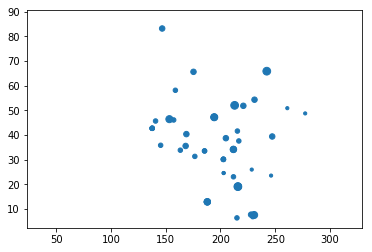

In [170]:
plt.scatter(scintel_pos[:,1][uniq_index], scintel_pos[:,2][uniq_index], s=10*scintel_pos[:,0][uniq_index])

(array([ 11.,   0.,   0.,  11.,   0.,   0.,  21.,   0.,   0.,   0.,   9.,
          0.,   0.,   7.,   0.,   0.,   5.,   0.,   0.,   3.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ,
         3.3,  3.6,  3.9,  4.2,  4.5,  4.8,  5.1,  5.4,  5.7,  6. ]),
 <a list of 20 Patch objects>)

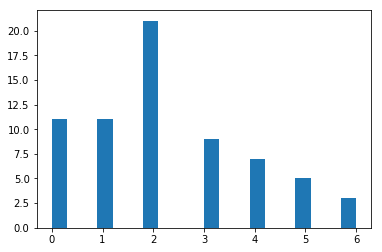

In [171]:
plt.hist(scintel_pos[:,0][uniq_index], bins=20)

In [172]:
scintel_pos[:,0][uniq_index].sum(), len(scintel_pos[:,0][uniq_index][scintel_pos[:,0][uniq_index] > 0])

(151.0, 56)

In [7]:
from scipy import signal
from scipy.signal import find_peaks, peak_widths

def make_mid_matches(hi_mid, low_mid):
    if len(hi_mid)*len(low_mid) == 0:
        return np.array([])
    
    out = []
    count = 0
    index = []
    # iterate shorter list to insure best 1-1 match
    if len(hi_mid) <= len(low_mid):
        for i in hi_mid:
            try:
                test = np.arange(len(low_mid))[np.logical_and(
                    np.abs(i - low_mid) == min(np.abs(i - low_mid)),
                    np.logical_and(i - low_mid >= pd.Timedelta('-120 seconds'),
                                   i - low_mid <= pd.Timedelta('20 seconds')))][0]
                out.append([i,low_mid[np.logical_and(
                    np.abs(i - low_mid) == min(np.abs(i - low_mid)),
                    np.logical_and(i - low_mid >= pd.Timedelta('-120 seconds'),
                                   i - low_mid <= pd.Timedelta('20 seconds')))][0]])
                
                index.append([count, test])

                count += 1
            except IndexError:
                count += 1
                continue
        return np.array(out, dtype='datetime64[ns]'), np.array(index)
    
    elif len(hi_mid) > len(low_mid):
        for i in low_mid:
            try:
                test = np.arange(len(hi_mid))[np.logical_and(
                    np.abs(i - hi_mid) == min(np.abs(i - hi_mid)),
                    np.logical_and(i - hi_mid >= pd.Timedelta('-120 seconds'),
                                   i - hi_mid <= pd.Timedelta('20 seconds')))][0]
                out.append([i, hi_mid[np.logical_and(
                    np.abs(i - hi_mid) == min(np.abs(i - hi_mid)),
                    np.logical_and(hi_mid - i >= pd.Timedelta('-120 seconds'),
                                   hi_mid - i <= pd.Timedelta('20 seconds')))][0]])
                
                index.append([count, test])

                count += 1
            except IndexError:
                count += 1
                continue
        # conditon 1 peak match
        try:
            return np.array(out, dtype='datetime64[ns]')[:,::-1], np.array(index)[:,::-1]
        except IndexError:
            return np.array(out, dtype='datetime64[ns]')[::-1], np.array(index)[::-1]



all_time_diff = np.array([])
all_time_out_df = pd.DataFrame([])


# _id = 162
rel_height = 0.9
skew_range = 5
kern_width = 3
kernel = np.ones(kern_width)

# for _id in lc_index[lc_index == True].index:
    
def count_scintels(_id, light_curves):
    rel_height = 0.9
    skew_range = 5
    kern_width = 3
    kernel = np.ones(kern_width)


    source_df = light_curves[light_curves.runcat == _id]
    source_df.taustart_ts = pd.to_datetime(source_df.taustart_ts)


    try:
        hi_source_flux = source_df.f_int[(source_df.freq_eff > 60000000) ].values
        hi_source_time = source_df.taustart_ts[(source_df.freq_eff > 60000000)].values

        hi_raw_df = pd.DataFrame({"flux":hi_source_flux, "time":hi_source_time}) 

        hi_reg_time = pd.date_range(start=np.min(hi_source_time-pd.Timedelta('1 seconds')), 
                                 end=np.max(hi_source_time+pd.Timedelta('1 seconds')), freq="1s")
        hi_reg_df = pd.DataFrame({"reg_flux":np.zeros(len(hi_reg_time)),"time":hi_reg_time })
        hi_reg_flux = pd.concat([hi_reg_df,hi_raw_df]).groupby("time").max().flux.fillna(0)

        hi_smoothed = signal.filtfilt(kernel,np.sum(kernel) ,hi_reg_flux, method="pad")


        low_source_flux = source_df.f_int[(source_df.freq_eff < 60000000) ].values
        low_source_time = source_df.taustart_ts[(source_df.freq_eff < 60000000)].values

        low_raw_df = pd.DataFrame({"flux":low_source_flux, "time":low_source_time}) 
        low_reg_time = pd.date_range(start=np.min(low_source_time-pd.Timedelta('1 seconds')), 
                                 end=np.max(low_source_time+pd.Timedelta('1 seconds')), freq="1s")
        low_reg_df = pd.DataFrame({"reg_flux":np.zeros(len(low_reg_time)),"time":low_reg_time })
        low_reg_flux = pd.concat([low_reg_df, low_raw_df]).groupby("time").max().flux.fillna(0)

        low_smoothed = signal.filtfilt(kernel,np.sum(kernel) ,low_reg_flux, method="pad")


        min_width = 5
        max_width = None

        # if _db[:3] == "ASr":
        min_prominence = 5
        # elif _db[:3] == "ASf":
        #     min_prominence = 30

        hi_peaks, hi_properties = signal.find_peaks(hi_smoothed, 
                                                prominence=[min_prominence,None], 
                                                width=[min_width ,max_width],
                                                rel_height=0.5)
        hi_results_full = peak_widths(hi_smoothed, hi_peaks, rel_height=rel_height)
        #     hi_results_full[0]  # widths

        low_peaks, low_properties = signal.find_peaks(low_smoothed, 
                                                      prominence=[min_prominence,None], 
                                                      width=[min_width ,max_width], 
                                                      rel_height=0.5)
        low_results_full = peak_widths(low_smoothed, low_peaks, rel_height=rel_height)
        #     low_results_full[0]  # widths


        hi_mid_time = hi_reg_time[np.array(hi_results_full[2], dtype="int")]+\
                   (hi_reg_time[np.array(hi_results_full[3], dtype="int")]-\
                   hi_reg_time[np.array(hi_results_full[2], dtype="int")])/2.

        low_mid_time = low_reg_time[np.array(low_results_full[2], dtype="int")]+\
                   (low_reg_time[np.array(low_results_full[3], dtype="int")]-\
                   low_reg_time[np.array(low_results_full[2], dtype="int")])/2.

        # match times

        time_out, time_ind_out = make_mid_matches(hi_mid_time, low_mid_time)

        # sort to later remove one-to-many matches 
        
        dif_arrange = np.argsort(np.abs(pd.to_datetime(time_out[:,0])- pd.to_datetime(time_out[:,1])))


        time_out_df = pd.DataFrame({"ID":_id*np.ones(len(dif_arrange)),
        #                             "vlssr":vlssr_flux.values*np.ones(len(dif_arrange)),
                                    "hi_time":time_out[:,0][dif_arrange],
                                    "low_time":time_out[:,1][dif_arrange],
                                    "hi_ind":time_ind_out[:,0][dif_arrange],
                                    "hi_flux":hi_reg_flux[hi_peaks[time_ind_out[:,0][dif_arrange]]].values,
                                    "hi_width":hi_results_full[0][time_ind_out[:,0][dif_arrange]],
                                    "low_ind":time_ind_out[:,1][dif_arrange],
                                    "low_flux":low_reg_flux[low_peaks[time_ind_out[:,1][dif_arrange]]].values,
                                    "low_width":low_results_full[0][time_ind_out[:,1][dif_arrange]],
                                    "time_dif":np.abs(pd.to_datetime(time_out[:,0])- pd.to_datetime(time_out[:,1]))[dif_arrange], 
                                    "natime_diff":(pd.to_datetime(time_out[:,0])- pd.to_datetime(time_out[:,1]))[dif_arrange].total_seconds()})


        # drop longer interval of one-to-many match
        time_out_df  = time_out_df.drop(time_out_df[np.logical_or(time_out_df.hi_time.duplicated(keep="first"),
                             time_out_df.low_time.duplicated(keep="first"))].index)

        # drop highly asymmetric pulses 
#         all_time_diff = np.append(all_time_diff, time_out_df[np.logical_and((np.abs((pd.to_datetime(low_mid_time)[time_out_df.low_ind] - \
#                                   pd.to_datetime(low_reg_time[low_peaks[time_out_df.low_ind]])).total_seconds()) <= skew_range),
#                   (np.abs((pd.to_datetime(hi_mid_time)[time_out_df.hi_ind] - \
#                                   pd.to_datetime(hi_reg_time[hi_peaks[time_out_df.hi_ind]])).total_seconds()) <= skew_range))].natime_diff.values)
        out_put = time_out_df[np.logical_and((np.abs((pd.to_datetime(low_mid_time)[time_out_df.low_ind] - \
                                                       pd.to_datetime(low_reg_time[low_peaks[time_out_df.low_ind]])).total_seconds()) <= skew_range),
                                              (np.abs((pd.to_datetime(hi_mid_time)[time_out_df.hi_ind] - \
                                                       pd.to_datetime(hi_reg_time[hi_peaks[time_out_df.hi_ind]])).total_seconds()) <= skew_range))]
        
    except ValueError:
        return 1
    except IndexError:
        return 1 
        
    return len(out_put)#, _id

# if len(all_time_out_df) == 0:
#     all_time_out_df = time_out_df[np.logical_and((np.abs((pd.to_datetime(low_mid_time)[time_out_df.low_ind] - \
#                               pd.to_datetime(low_reg_time[low_peaks[time_out_df.low_ind]])).total_seconds()) <= skew_range),
#               (np.abs((pd.to_datetime(hi_mid_time)[time_out_df.hi_ind] - \
#                               pd.to_datetime(hi_reg_time[hi_peaks[time_out_df.hi_ind]])).total_seconds()) <= skew_range))]
# elif len(all_time_out_df) > 0:
#     all_time_out_df = pd.concat([all_time_out_df,time_out_df[np.logical_and((np.abs((pd.to_datetime(low_mid_time)[time_out_df.low_ind] - \
#                               pd.to_datetime(low_reg_time[low_peaks[time_out_df.low_ind]])).total_seconds()) <= skew_range),
#               (np.abs((pd.to_datetime(hi_mid_time)[time_out_df.hi_ind] - \
#                               pd.to_datetime(hi_reg_time[hi_peaks[time_out_df.hi_ind]])).total_seconds()) <= skew_range))]])





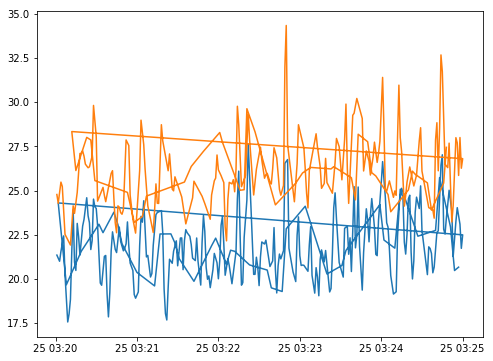

In [8]:
_id = 284

source_df = light_curves[light_curves.runcat == _id]
source_df.taustart_ts = pd.to_datetime(source_df.taustart_ts)

source_df
plt.figure(figsize=(8,6))
plt.plot(source_df[source_df.freq_eff > 60000000].taustart_ts,
         source_df[source_df.freq_eff > 60000000].f_int.rolling(2).mean(), )
plt.plot(source_df[source_df.freq_eff < 60000000].taustart_ts,
         source_df[source_df.freq_eff < 60000000].f_int.rolling(2).mean(), )

In [19]:
times = pd.date_range(start='2017-02-25 01:30:00', 
                      end="2017-02-25 05:08:00",  freq="300s")
frame = 22

times[frame]

Timestamp('2017-02-25 03:20:00', freq='300S')

In [9]:
from joblib import Parallel, delayed
import scipy.stats as st

aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
ateam = pd.DataFrame({"ra":np.array([82.88,299.43,350.28,187.07]), "decl":np.array([21.98,40.59,58.54,12.66])})

CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')


dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

# dbname = "ASr_20181027"
# times = pd.date_range(start='2018-10-27 07:00:10', 
#                       periods=92*300,  freq="300s")

# frame = 6

dbname = "ASr_201702250130"
times = pd.date_range(start='2017-02-25 01:30:00', 
                      end="2017-02-25 05:08:00",  freq="300s")
frame = 22


# dbname = "ASf_201905190430"
# times = pd.date_range(start='2018-03-09 15:30:00', 
#                       end="2018-03-10 03:45:00",  freq="300s")

# frame = 106


db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = '''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.freq_eff, im.taustart_ts 
            FROM extractedsource ex, assocxtrsource ax, image im  
            WHERE im.taustart_ts BETWEEN '%s' AND '%s'  AND ex.extract_type = 0 
            AND ax.xtrsrc = ex.id AND ex.image = im.id;'''% (times[frame], times[frame+1])

# transients_query = '''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band, im.taustart_ts 
#             FROM extractedsource ex, assocxtrsource ax, image im  
#             WHERE im.taustart_ts BETWEEN '%s' AND '%s'  AND ex.extract_type = 0 
#             AND ax.xtrsrc = ex.id AND ex.image = im.id;'''% (times[frame], times[frame+1])

light_curves = pd.DataFrame(run_query(transients_query, dbname, 
                                      dataset, engine, host, port, user, password))

db._configured = False
del db, session

lc_index = light_curves.groupby("runcat").size() > 6

tot_df = pd.DataFrame({"ra":[],"decl":[], 
                       "f_avg":[],"f_std":[]})

xmin, xmax = -55, 55
ymin, ymax = -55, 55


for i in lc_index.index:
    if not lc_index.loc[i]:
        continue

    light_curve = light_curves[light_curves.runcat == i]


    sr_x, sr_y = pol2cart(np.abs(90-light_curve.decl.mean()),
            np.deg2rad(light_curve.ra.mean()))

# filter AARTFAAC source 
    cat_x, cat_y = pol2cart(np.abs(90-aart.decl),
            np.deg2rad(aart.ra))

    index = distSquared((sr_x,sr_y),
               np.array([cat_x, cat_y]))

    if type(index) == np.ndarray:
        continue 

# filter ateam 
    cat_x, cat_y = pol2cart(np.abs(90-ateam.decl),
            np.deg2rad(ateam.ra))

    index = distSquared((sr_x,sr_y),
               np.array([cat_x, cat_y]), r=5.0)

    if type(index) == np.ndarray:
        continue 

# filter sun
    sun_pos = pd.DataFrame({"ra":[astropy.coordinates.get_sun(astropy.time.Time((times[1]-times[0])/2.+times[0])).ra.deg],
               "decl":[astropy.coordinates.get_sun(astropy.time.Time((times[1]-times[0])/2.+times[0])).dec.deg]})

    cat_x, cat_y = pol2cart(np.abs(90-sun_pos.decl),
            np.deg2rad(sun_pos.ra))

    index = distSquared((sr_x,sr_y),
               np.array([cat_x, cat_y]), r=5.0)

    if type(index) == np.ndarray:
        continue 
        
        
    light_curve["flux"] = light_curve.f_int
    light_curve["time"] = light_curve.taustart_ts

    reg_time = pd.date_range(start=np.min(pd.to_datetime(light_curve.taustart_ts)), 
                     end=np.max(pd.to_datetime(light_curve.taustart_ts)), freq="1s")

    reg_df = pd.DataFrame({"flux":np.zeros(len(reg_time)),"time":reg_time })
    reg_flux = pd.concat([reg_df,light_curve ]).groupby("time").max().flux.fillna(0)

    n_scint = count_scintels(i, light_curves)
    
    for i in range(n_scint):
        tot_df = tot_df.append({"ra":light_curve.ra.mean(),
                                "decl":light_curve.decl.mean(),
                                "f_avg":reg_flux.mean(),
                                "f_std":reg_flux.std()},
                               ignore_index=True)
print "Done"

Done


In [186]:
scint_counts = tot_df.groupby("ra").count().decl.values

(array([ 78.,  26.,   5.,   2.,   4.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 5 Patch objects>)

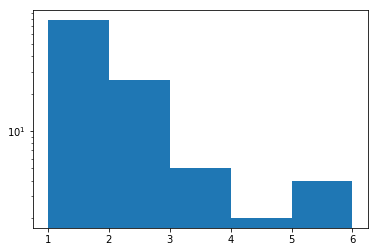

In [204]:
plt.hist(tot_df.groupby("ra").count().decl.values, bins = 5, log=True)

In [10]:

list_ra = [x*u.degree for x in tot_df.ra]
list_decl = [x*u.degree for x in tot_df.decl]



position = SkyCoord(list_ra, list_decl)


obs_times = [times[int(frame)]] 

altaz = position.transform_to(AltAz(obstime=obs_times*len(list_ra), location=CS002))
AART_altaz = SkyCoord(aart.ra.values*u.deg, 
                      aart.decl.values*u.deg).transform_to(AltAz(obstime=obs_times*len(aart.ra),
                                                             location=CS002))

ecliptic = SkyCoord(np.concatenate([np.linspace(-180,180,360),
                           np.linspace(-180,180,360),
                           np.linspace(-180,180,360),
                           np.linspace(-180,180,360),
                                   180*np.ones(180),
                                   0*np.ones(180),
                                   90*np.ones(180),
                                   270*np.ones(180)]), 
                np.concatenate([np.zeros(360),
                           20*np.ones(360),
                           40*np.ones(360),
                           60*np.ones(360),
                            np.linspace(-90,90,180),
                               np.linspace(-90,90,180),
                               np.linspace(-90,90,180),
                               np.linspace(-90,90,180)]), 
                unit="deg", 
                frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*(4*360+4*180), location=CS002))
#TR 163.37 33.73


TR_loc = SkyCoord(163.37,33.73,unit="deg",
                  frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*4, location=CS002))

sun_op_lon = (SkyCoord(sun_pos.ra.values, sun_pos.decl.values, 
         unit="deg",frame="fk5").transform_to('barycentrictrueecliptic').lon.deg-180. ) % 360

sun_opposition = SkyCoord(sun_op_lon*np.ones(100), 
                          np.linspace(0,90,100), unit="deg",
                          frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*(100), 
                                                                              location=CS002))


text_ecliptic = SkyCoord([180,180,180,180],[0,20,40,60],unit="deg", 
                         frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*4, location=CS002))

Galactic = SkyCoord(np.linspace(0,360,360), np.zeros(360), 
                    unit="deg", frame="galactic" ).transform_to(AltAz(obstime=obs_times*(360), location=CS002))


text_ecliptic_x = -pol2cart((90-text_ecliptic.alt.deg), text_ecliptic.az.rad,)[1]
text_ecliptic_y = pol2cart((90-text_ecliptic.alt.deg), text_ecliptic.az.rad,)[0]

AltAz_x = -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]
AltAz_y = pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0]

aart_x = -pol2cart((90-AART_altaz.alt.deg), AART_altaz.az.rad,)[1]
aart_y = pol2cart((90-AART_altaz.alt.deg), AART_altaz.az.rad,)[0]

ecliptic_x = -pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[1]
ecliptic_y = pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[0]

Galactic_x = -pol2cart((90-Galactic.alt.deg), Galactic.az.rad,)[1]
Galactic_y = pol2cart((90-Galactic.alt.deg), Galactic.az.rad,)[0]

sun_opposition_x = -pol2cart((90-sun_opposition.alt.deg), sun_opposition.az.rad,)[1]
sun_opposition_y = pol2cart((90-sun_opposition.alt.deg), sun_opposition.az.rad,)[0]

TR_loc_x = -pol2cart((90-TR_loc.alt.deg), TR_loc.az.rad,)[1]
TR_loc_y = pol2cart((90-TR_loc.alt.deg), TR_loc.az.rad,)[0]


AltAz_x, AltAz_y = AltAz_x[(np.sqrt(AltAz_x**2. + AltAz_y**2.) < 55)], AltAz_y[(np.sqrt(AltAz_x**2. + AltAz_y**2.) < 55)]

aart_x, aart_y = aart_x[(np.sqrt(aart_x**2. + aart_y**2.) < 55)], aart_y[(np.sqrt(aart_x**2. + aart_y**2.) < 55)]

ecliptic_x, ecliptic_y = ecliptic_x[(np.sqrt(ecliptic_x**2. + ecliptic_y**2.) < 55)], ecliptic_y[(np.sqrt(ecliptic_x**2. + ecliptic_y**2.) < 55)]  

Galactic_x, Galactic_y = Galactic_x[(np.sqrt(Galactic_x**2. + Galactic_y**2.) < 55)], Galactic_y[(np.sqrt(Galactic_x**2. + Galactic_y**2.) < 55)]  

sun_opposition_x, sun_opposition_y = sun_opposition_x[(np.sqrt(sun_opposition_x**2. + sun_opposition_y**2.) < 55)], sun_opposition_y[(np.sqrt(sun_opposition_x**2. + sun_opposition_y**2.) < 55)]  

TR_loc_x, TR_loc_y = TR_loc_x[(np.sqrt(TR_loc_x**2. + TR_loc_y**2.) < 55)], TR_loc_y[(np.sqrt(TR_loc_x**2. + TR_loc_y**2.) < 55)]  


print "done"


done


175.0 175


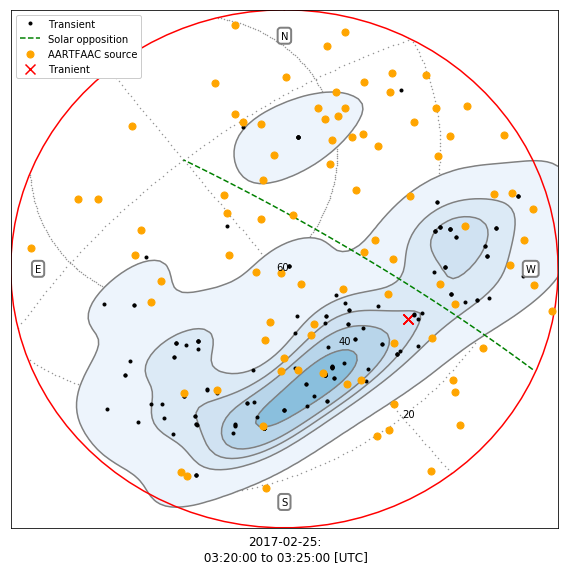

In [90]:
# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([AltAz_x, AltAz_y])
kernel = st.gaussian_kde(values, bw_method=0.35 )
f = np.reshape(kernel(positions).T, xx.shape)
f *= kernel.n/(np.sum(kernel(positions)))

print np.sum(f), len(AltAz_x)

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.plot(AltAz_x, AltAz_y, ".", c="k", label="Transient")

ax.scatter(ecliptic_x, ecliptic_y,
           c="grey", s=0.2, label=None)

ax.scatter(Galactic_x, Galactic_y,
           c="red", s=0.2, label=None)

ax.scatter(aart_x, aart_y, marker="o",
           c="orange", s=50, label="AARTFAAC source", zorder=5)

ax.plot(sun_opposition_x, sun_opposition_y, "--",
           c="green", label="Solar opposition")





ax.plot(-pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[1],
        pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[0],"r")

# for t_x, t_y, t_s in zip(text_ecliptic_x,text_ecliptic_y,['0','20','40','60']) :
#     ax.text(t_x, t_y, t_s, zorder=999)
for t_x, t_y, t_s in zip(text_ecliptic_x,text_ecliptic_y,['0','20','40','60']) :
    if (np.sqrt(t_x**2. + t_y**2.) > 55):
        continue 
    ax.text(t_x, t_y, t_s, zorder=5)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


levels = [1e-2, 0.5e-1, 0.75e-1, 1e-1, 1.5e-1, 2e-1, 
          2.5e-1, 3e-1, 3.5e-1, 4e-1]


# Contourf plot
cfset = ax.contourf(xx, yy, f, levels, cmap='Blues', label="Source KDE")
# Contour plot
cset = ax.contour(xx, yy, f, levels, colors='grey', label="Source KDE")

ax.scatter(TR_loc_x, TR_loc_y, c="red", marker="x", s=100, label="Tranient")

# Label plot
#     ax.clabel(cset, inline=1, fontsize=10)
plt.title(str(times[int(frame)].date())+":\n "
          +str(times[int(frame)].time())+" to "
          +str(str(times[int(frame)+1].time()))+" [UTC]",y=-0.025, va="top")



bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=2)
plt.annotate("S", (0.0,0.3), xytext=(0.5,0.05), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("N", (0.0,0.3), xytext=(0.5,0.95),  zorder=99,
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   

plt.annotate("W", (0.0,0.3), xytext=(0.95,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("E", (0.0,0.3), xytext=(0.05,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")    
    


# plt.scatter(xx[(f == f.max())],  
#             yy[(f == f.max())], s=1000, marker="X", c="r")

ax.set_xticks([])
ax.set_yticks([])

# ax.legend(loc="lower left", framealpha=1)
ax.legend(loc="upper left", framealpha=1)
# ax.set_aspect("equal")
plt.tight_layout()


In [76]:
# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([AltAz_x, AltAz_y])
kernel = st.gaussian_kde(values, bw_method=0.35)
f = np.reshape(kernel(positions).T, xx.shape)
f *= kernel.n/(np.sum(kernel(positions)))

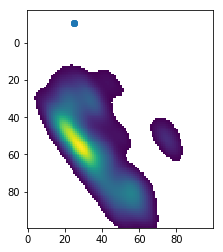

In [83]:
f_img = f

f_img[f < 1e-2] = np.nan
plt.figure()
plt.imshow(f)
plt.scatter(TR_loc_x, TR_loc_y)

In [81]:
kernel([TR_loc_x, TR_loc_y])

array([ 0.00036574,  0.00036574,  0.00036574,  0.00036574])

In [91]:
TR_loc_x, TR_loc_y

(array([ 24.90814254,  24.90814254,  24.90814254,  24.90814254]),
 array([-10.61000196, -10.61000196, -10.61000196, -10.61000196]))

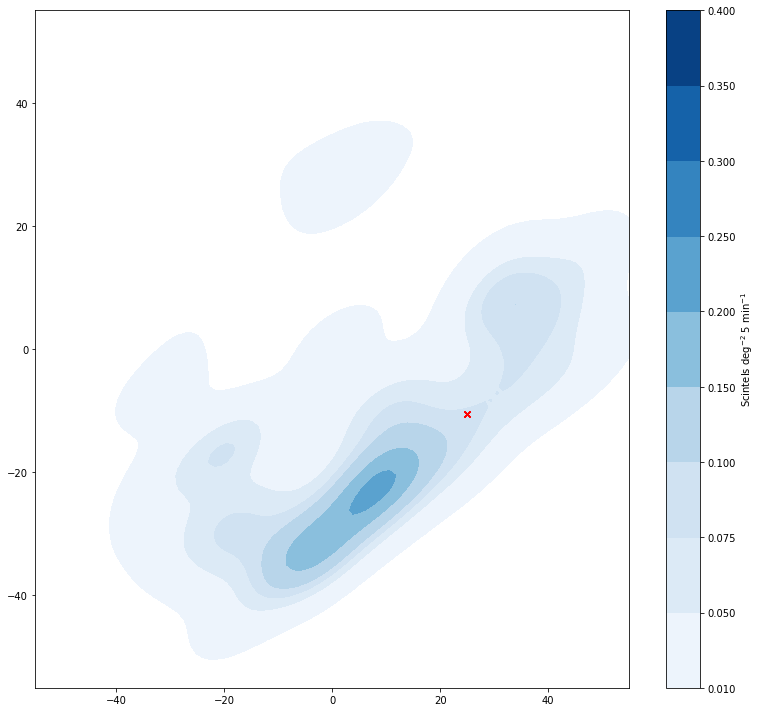

In [127]:
kernel = st.gaussian_kde(values, bw_method=0.3)
f = np.reshape(kernel(positions).T, xx.shape)
f *= kernel.n/(np.sum(kernel(positions)))


levels = np.array([1e-2, 0.5e-1, 0.75e-1, 1e-1, 1.5e-1, 2e-1,
                   2.5e-1, 3e-1, 3.5e-1, 4e-1])

fig = plt.figure(figsize=(11,10))
ax = fig.gca()
cfset = plt.contourf(xx, yy, f, levels, cmap='Blues', label="contourf") 
cbar = plt.colorbar()
cbar.set_label(r'Scintels ${\rm deg}^{-2}$ 5 ${\rm min}^{-1}$')

plt.scatter(TR_loc_x, TR_loc_y, marker="x", color="red")
plt.tight_layout()

In [104]:
kernel = st.gaussian_kde(values, bw_method=0.35)
f = np.reshape(kernel(positions).T, xx.shape)
f *= kernel.n/(np.sum(kernel(positions)))

In [109]:
kernel((TR_loc_x, TR_loc_y))*kernel.n/(np.sum(kernel(positions)))

# KDE evaluated at transient location 0.0796048, but what units ? scintel per element 

array([ 0.0796048,  0.0796048,  0.0796048,  0.0796048])

In [128]:
0.08 scintel per deg2 per 5 min 

3025

In [138]:
0.08 / (60./5.)

0.006666666666666667

In [136]:
1./0.007

142.85714285714286

In [130]:
1 scintel per 143 degrees2 per second

12.5

In [1]:


# # Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:110j, ymin:ymax:110j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([AltAz_x, AltAz_y])
kernel = st.gaussian_kde(values, bw_method=0.35 )
f = np.reshape(kernel.evaluate(positions).T, xx.shape)

# print np.sum(kernel)
# print (len(values[0]))

f *= kernel.n/(np.sum(kernel(positions)))

print np.sum(f)
print len(values[0])
# kernel(positions)
plt.imshow(f.T, origin="lower")
plt.colorbar()

levels = [1e-1, 1.5e-1, 2e-1, 
          2.5e-1, 3e-1, 3.5e-1, 4e-1,4.5e-1,5e-1]
plt.figure()
# Contourf plot
plt.contourf(xx, yy, f, levels, cmap='Blues', label="Source KDE")
cbar = plt.colorbar()
cbar.set_label('Scintels deg^{-2} 5 min^{-1}')
# Contour plot
plt.contour(xx, yy, f, levels, colors='grey', label="Source KDE")


NameError: name 'np' is not defined

NameError: name 'kernal' is not defined

done
165.0 165
done
175.0 175
done
181.0 181


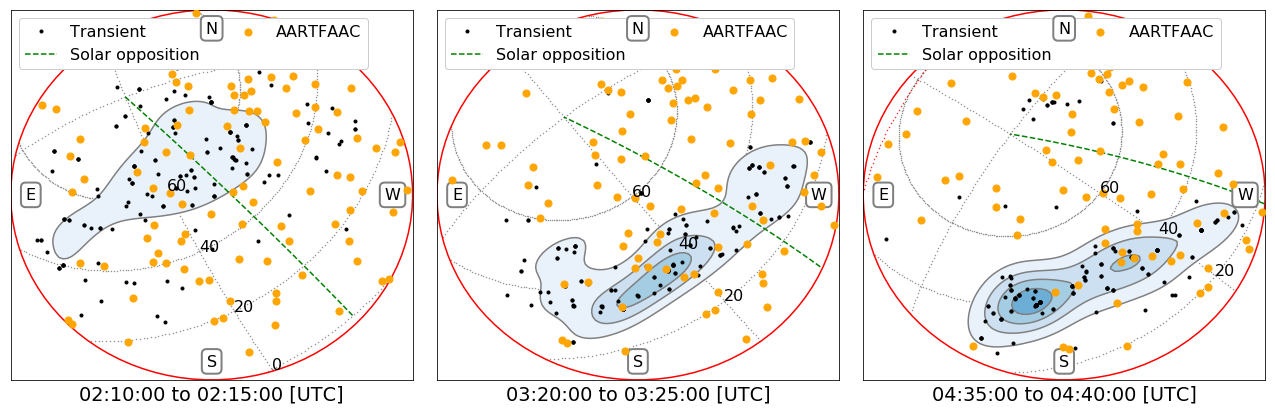

In [29]:
from joblib import Parallel, delayed
import scipy.stats as st
import matplotlib 

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16
       }
matplotlib.rc('font', **font)

aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
ateam = pd.DataFrame({"ra":np.array([82.88,299.43,350.28,187.07]), "decl":np.array([21.98,40.59,58.54,12.66])})

CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')



dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

# dbname = "ASr_20181027"
# times = pd.date_range(start='2018-10-27 07:00:10', 
#                       periods=92*300,  freq="300s")

# frame = 6

dbname = "ASr_201702250130"
times = pd.date_range(start='2017-02-25 01:30:00', 
                      end="2017-02-25 05:08:00",  freq="300s")
frame = 8

_frames = [8,22,37]

count = 1 
fig = plt.figure(figsize=(18,6))

for frame in _frames:
    
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()

    transients_query = '''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.freq_eff, im.taustart_ts 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '%s' AND '%s'  AND ex.extract_type = 0 
                AND ax.xtrsrc = ex.id AND ex.image = im.id;'''% (times[frame], times[frame+1])

    light_curves = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

    db._configured = False
    del db, session

    lc_index = light_curves.groupby("runcat").size() > 6

    tot_df = pd.DataFrame({"ra":[],"decl":[], "f_avg":[],"f_std":[]})

    xmin, xmax = -55, 55
    ymin, ymax = -55, 55


    for i in lc_index.index:
        if not lc_index.loc[i]:
            continue

        light_curve = light_curves[light_curves.runcat == i]

        sr_x, sr_y = pol2cart(np.abs(90-light_curve.decl.mean()),
                np.deg2rad(light_curve.ra.mean()))

        cat_x, cat_y = pol2cart(np.abs(90-aart.decl),
                np.deg2rad(aart.ra))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            continue 

        cat_x, cat_y = pol2cart(np.abs(90-ateam.decl),
                np.deg2rad(ateam.ra))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]), r=10.0)

        if type(index) == np.ndarray:
            continue 

        sun_pos = pd.DataFrame({"ra":[astropy.coordinates.get_sun(astropy.time.Time((times[1]-times[0])/2.+times[0])).ra.deg],
                   "decl":[astropy.coordinates.get_sun(astropy.time.Time((times[1]-times[0])/2.+times[0])).dec.deg]})

        cat_x, cat_y = pol2cart(np.abs(90-sun_pos.decl),
                np.deg2rad(sun_pos.ra))

        index = distSquared((sr_x, sr_y),
                   np.array([cat_x, cat_y]), r=5.0)

        if type(index) == np.ndarray:
            continue 


        light_curve["flux"] = light_curve.f_int
        light_curve["time"] = light_curve.taustart_ts

        reg_time = pd.date_range(start=np.min(pd.to_datetime(light_curve.taustart_ts)), 
                         end=np.max(pd.to_datetime(light_curve.taustart_ts)), freq="1s")

        reg_df = pd.DataFrame({"flux":np.zeros(len(reg_time)),"time":reg_time })
        reg_flux = pd.concat([reg_df,light_curve]).groupby("time").max().flux.fillna(0)

        n_scint = count_scintels(i, light_curves)

        for i in range(n_scint):
            tot_df = tot_df.append({"ra":light_curve.ra.mean(),
                                    "decl":light_curve.decl.mean(),
                                    "f_avg":reg_flux.mean(),
                                    "f_std":reg_flux.std()},
                                   ignore_index=True)

#         tot_df = tot_df.append({"ra":light_curve.ra.mean(),
#                                 "decl":light_curve.decl.mean(),
#                                 "f_avg":reg_flux.mean(),
#                                 "f_std":reg_flux.std()},
#                                ignore_index=True)



    list_ra = [x*u.degree for x in tot_df.ra]
    list_decl = [x*u.degree for x in tot_df.decl]

    position = SkyCoord(list_ra, list_decl)


    obs_times = [times[int(frame)]] 

    altaz = position.transform_to(AltAz(obstime=obs_times*len(list_ra), location=CS002))
    AART_altaz = SkyCoord(aart.ra.values*u.deg, 
                          aart.decl.values*u.deg).transform_to(AltAz(obstime=obs_times*len(aart.ra),
                                                                 location=CS002))

    ecliptic = SkyCoord(np.concatenate([np.linspace(-180,180,360),
                               np.linspace(-180,180,360),
                               np.linspace(-180,180,360),
                               np.linspace(-180,180,360),
                                       180*np.ones(180),
                                       0*np.ones(180),
                                       90*np.ones(180),
                                       270*np.ones(180)]), 
                    np.concatenate([np.zeros(360),
                               20*np.ones(360),
                               40*np.ones(360),
                               60*np.ones(360),
                                np.linspace(-90,90,180),
                                   np.linspace(-90,90,180),
                                   np.linspace(-90,90,180),
                                   np.linspace(-90,90,180)]), 
                    unit="deg", 
                    frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*(4*360+4*180), location=CS002))



    sun_op_lon = (SkyCoord(sun_pos.ra.values, sun_pos.decl.values, 
             unit="deg",frame="fk5").transform_to('barycentrictrueecliptic').lon.deg-180. ) % 360

    sun_opposition = SkyCoord(sun_op_lon*np.ones(100), 
                              np.linspace(0,90,100), unit="deg",
                              frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*(100), 
                                                                                  location=CS002))



    text_ecliptic = SkyCoord([180,180,180,180],[0,20,40,60],unit="deg", 
                             frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*4, location=CS002))

    Galactic = SkyCoord(np.linspace(0,360,360), np.zeros(360), 
                        unit="deg", frame="galactic" ).transform_to(AltAz(obstime=obs_times*(360), location=CS002))


    text_ecliptic_x = -pol2cart((90-text_ecliptic.alt.deg), text_ecliptic.az.rad,)[1]
    text_ecliptic_y = pol2cart((90-text_ecliptic.alt.deg), text_ecliptic.az.rad,)[0]

    AltAz_x = -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]
    AltAz_y = pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0]

    aart_x = -pol2cart((90-AART_altaz.alt.deg), AART_altaz.az.rad,)[1]
    aart_y = pol2cart((90-AART_altaz.alt.deg), AART_altaz.az.rad,)[0]

    ecliptic_x = -pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[1]
    ecliptic_y = pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[0]

    Galactic_x = -pol2cart((90-Galactic.alt.deg), Galactic.az.rad,)[1]
    Galactic_y = pol2cart((90-Galactic.alt.deg), Galactic.az.rad,)[0]

    sun_opposition_x = -pol2cart((90-sun_opposition.alt.deg), sun_opposition.az.rad,)[1]
    sun_opposition_y = pol2cart((90-sun_opposition.alt.deg), sun_opposition.az.rad,)[0]


    AltAz_x, AltAz_y = AltAz_x[(np.sqrt(AltAz_x**2. + AltAz_y**2.) < 55)],\
    AltAz_y[(np.sqrt(AltAz_x**2. + AltAz_y**2.) < 55)]

    aart_x, aart_y = aart_x[(np.sqrt(aart_x**2. + aart_y**2.) < 55)],\
    aart_y[(np.sqrt(aart_x**2. + aart_y**2.) < 55)]

    ecliptic_x, ecliptic_y = ecliptic_x[(np.sqrt(ecliptic_x**2. + ecliptic_y**2.) < 55)],\
    ecliptic_y[(np.sqrt(ecliptic_x**2. + ecliptic_y**2.) < 55)]  

    Galactic_x, Galactic_y = Galactic_x[(np.sqrt(Galactic_x**2. + Galactic_y**2.) < 55)],\
    Galactic_y[(np.sqrt(Galactic_x**2. + Galactic_y**2.) < 55)]  

    sun_opposition_x, sun_opposition_y = sun_opposition_x[(np.sqrt(sun_opposition_x**2. + sun_opposition_y**2.) < 55)],\
    sun_opposition_y[(np.sqrt(sun_opposition_x**2. + sun_opposition_y**2.) < 55)]  

    print "done"



    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([AltAz_x, AltAz_y])
    kernel = st.gaussian_kde(values, bw_method=0.35 )
    
    f = np.reshape(kernel(positions).T, xx.shape)
    f *= kernel.n/(np.sum(kernel(positions)))
    print np.sum(f), len(AltAz_x)

    sb = plt.subplot(1,3,count)

    ax = fig.gca()
    
    ax.plot(AltAz_x, AltAz_y, ".", c="k", label="Transient")

    ax.scatter(ecliptic_x, ecliptic_y,
               c="grey", s=0.2, label=None)

    ax.scatter(Galactic_x, Galactic_y,
               c="red", s=0.2, label=None)

    ax.scatter(aart_x, aart_y, marker="o",
               c="orange", s=50, label="AARTFAAC", zorder=5)

    ax.plot(sun_opposition_x, sun_opposition_y, "--",
               c="green", label="Solar opposition")


    ax.plot(-pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[1],
            pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[0],"r")

    for t_x, t_y, t_s in zip(text_ecliptic_x,text_ecliptic_y,['0','20','40','60']) :
        if (np.sqrt(t_x**2. + t_y**2.) > 55):
            continue 
        ax.text(t_x, t_y, t_s, zorder=5)


    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


    levels = [0.5e-1,1e-1,1.5e-1, 2e-1, 2.5e-1,3e-1, 3.5e-1,4e-1, ]

    # Contourf plot
    cfset = plt.contourf(xx, yy, f, levels, cmap='Blues', label="contourf")
    
#     if count == 3:
#         cbar = plt.colorbar()
#         cbar.set_label(r'Scintels ${\rm deg}^{-2}$ 5 ${\rm min}^{-1}$')

    # Contour plot
    cset = ax.contour(xx, yy, f, levels, colors='grey')

    # Label plot
    #     ax.clabel(cset, inline=1, fontsize=10)
    plt.title(str(times[int(frame)].time())+" to "+str(str(times[int(frame)+1].time()))+" [UTC]",y=-0.07 )

    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=2)
    plt.annotate("S", (0.0,0.3), xytext=(0.5,0.05), 
                 xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
    plt.annotate("N", (0.0,0.3), xytext=(0.5,0.95),  zorder=99,
                 xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   

    plt.annotate("W", (0.0,0.3), xytext=(0.95,0.5), 
                 xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
    plt.annotate("E", (0.0,0.3), xytext=(0.05,0.5), 
                 xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")    
    
    # plt.scatter(xx[(f == f.max())],  yy[(f == f.max())], s=1000, marker="X", c="r")

    ax.set_xticks([])
    ax.set_yticks([])

    ax.legend(ncol=2,loc="upper left", framealpha=1)
    # ax.set_aspect("equal")
    plt.tight_layout()
    count += 1
    
# plt.savefig("/home/kuiack/mag_figs/strip_evol_3.pdf", bbox_inches = 'tight' )



In [225]:

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, 
    for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)


def cart2pol(x, y):
    """
     Cartesian to Polar coordinate conversion, 
     for distance measure around celestial pole.
    """
    r = np.sqrt( x**2. + y**2 )
    theta = np.arctan(y/x )
    
    if (y >= 0) and (x >= 0):
        return r, theta 
    elif ((y > 0) and (x < 0)) or ((y < 0) and (x < 0)):
        return r, theta+np.pi
    elif ((y < 0) and (x > 0)):
        return r, theta+(2*np.pi)

# AltAz_x = -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]
# AltAz_y = pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0]



r = 0.0
theta = np.deg2rad(90)

print r, theta

r_x = -pol2cart((90-r), theta)[1]
r_y = pol2cart((90-r), theta)[0]

print "x:",r_y, "y:",-r_x

r_alt, r_az =  cart2pol(r_y, -r_x)
alt = r_alt

print alt, r_az

0.0 1.57079632679
x: 5.51091059616e-15 y: 90.0
90.0 1.57079632679


In [228]:

# r_alt, r_az =  cart2pol(yy[f == f.max()], -xx[f == f.max()])
# alt = 90-r_alt


strip_loc = SkyCoord( r_az*u.rad,r_alt*u.deg, frame="altaz", 
         obstime=times[int(frame)], location=CS002).transform_to("fk5")

In [231]:
print strip_loc.ra.deg, strip_loc.dec.deg

179.266626446 53.0172402585


In [190]:
The value of tan-1( y/x ) may need to be adjusted:

Quadrant I: Use the calculator value
Quadrant II: Add 180°
Quadrant III: Add 180°
Quadrant IV: Add 360°

-60.945395900922861

(array([ 40.,  11.,   4.,  21.,  41.,  82.,  91.,  87.,  31.,  11.]),
 array([  1.07933950e-01,   3.50322131e+01,   6.99564923e+01,
          1.04880772e+02,   1.39805051e+02,   1.74729330e+02,
          2.09653609e+02,   2.44577888e+02,   2.79502168e+02,
          3.14426447e+02,   3.49350726e+02]),
 <a list of 10 Patch objects>)

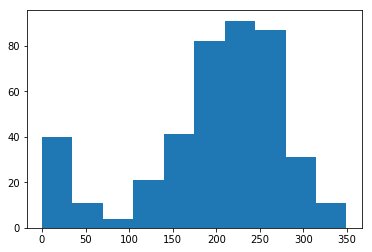

In [139]:
plt.hist(altaz.az.deg)

In [ ]:
dbname = "ASf_201803091515"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)


tot_df = pd.DataFrame({"ra":[],"decl":[],"runcat":[],"f_avg":[],"f_std":[], "frame":[]})

n=0

times = pd.date_range(start='2018-03-09 15:30:00', 
                      end="2018-03-10 03:45:00",  freq="300s")

for i in range(len(times)-1)[:

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()


    print times[i], times[i+1]

    transients_query = '''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band, im.taustart_ts 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '%s' AND '%s'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;'''% (times[i], times[i+1])
    print transients_query
    light_curves = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

    # AS_databases = [x for x in databases.datname if (x[:3] == "ASf" or x[:3] == "ASr")]

    db._configured = False
    del db, session

    lc_index = light_curves.groupby("runcat").size() > 0
    print len(lc_index)
    
    for i in lc_index.index:
        if not lc_index.loc[i]:
            continue

        light_curve = light_curves[light_curves.runcat == i]

        light_curve["flux"] = light_curve.f_int
        light_curve["time"] = light_curve.taustart_ts

        reg_time = pd.date_range(start=np.min(pd.to_datetime(light_curve.taustart_ts)), 
                         end=np.max(pd.to_datetime(light_curve.taustart_ts)), freq="1s")
        
        reg_df = pd.DataFrame({"flux":np.zeros(len(reg_time)),"time":reg_time })
        reg_flux = pd.concat([reg_df,light_curve ]).groupby("time").max().flux.fillna(0)

#         tot_df = tot_df.append({"ra":light_curve.ra.mean(),
#                                 "decl":light_curve.decl.mean(),
#                                 "runcat":light_curve.runcat.mean(),
#                                 "f_avg":light_curve.f_int.mean(),
#                                 "f_std":light_curve.f_int.std(),
#                                 "frame":n},
#                                ignore_index=True)

        tot_df = tot_df.append({"ra":light_curve.ra.mean(),
                                "decl":light_curve.decl.mean(),
                                "f_avg":reg_flux.mean(),
                                "f_std":reg_flux.std(),
                                "frame":n},
                               ignore_index=True)
    n+=1

tot_df = tot_df.groupby("ra").mean().reset_index()

database name:  ASf_201803091515
2018-03-09 15:30:00 2018-03-09 15:35:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band, im.taustart_ts 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2018-03-09 15:30:00' AND '2018-03-09 15:35:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;
190


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-03-09 15:35:00 2018-03-09 15:40:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band, im.taustart_ts 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2018-03-09 15:35:00' AND '2018-03-09 15:40:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;
198
2018-03-09 15:40:00 2018-03-09 15:45:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band, im.taustart_ts 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2018-03-09 15:40:00' AND '2018-03-09 15:45:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;
226
2018-03-09 15:45:00 2018-03-09 15:50:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band, im.taustart_ts 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2018-03-09 15:45:00' A

In [ ]:
print "hellp"

In [23]:
light_curve["flux"] = light_curve.f_int
light_curve["time"] = light_curve.taustart_ts


pd.date_range(start=np.min(pd.to_datetime(light_curve.taustart_ts)), 
                 end=np.max(pd.to_datetime(light_curve.taustart_ts)), freq="1s")
reg_df = pd.DataFrame({"flux":np.zeros(len(reg_time)),"time":reg_time })
reg_flux = pd.concat([reg_df,light_curve ]).groupby("time").max().flux.fillna(0)

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


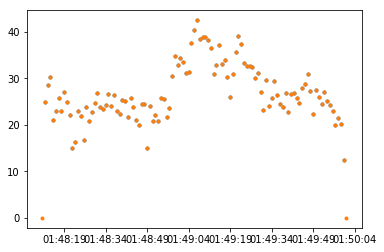

In [24]:
plt.plot(light_curve.taustart_ts,light_curve.flux,".")
plt.plot(reg_flux,".")

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in absolute
  import sys
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


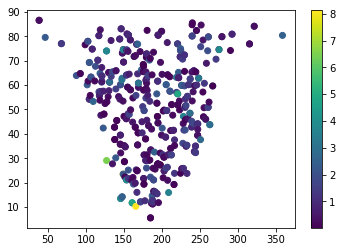

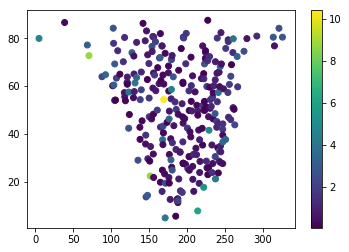

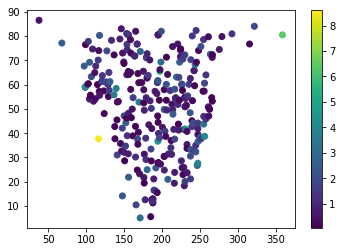

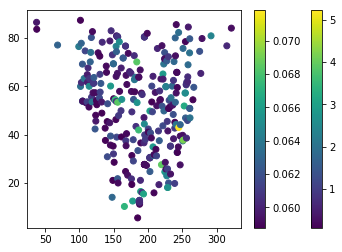

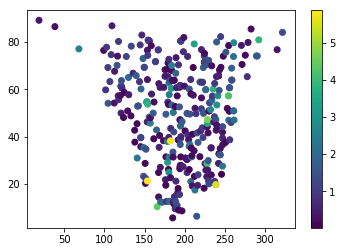

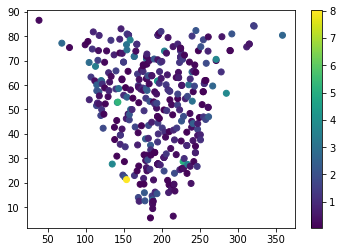

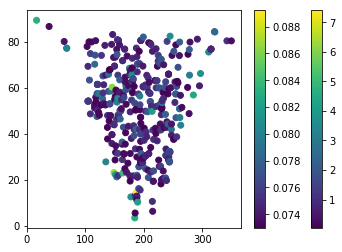

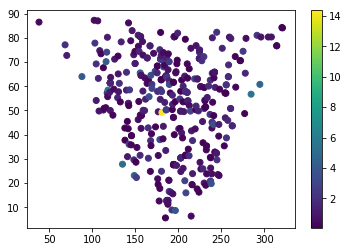

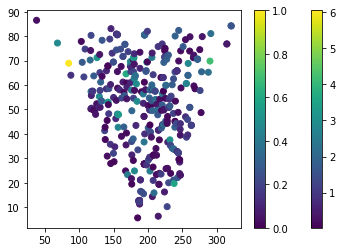

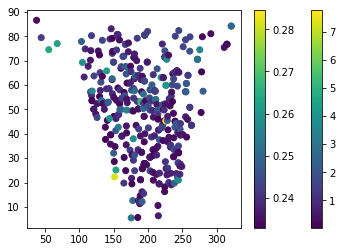

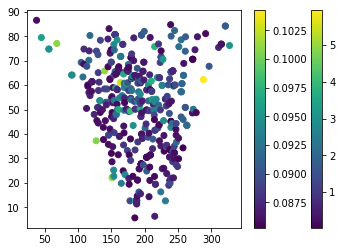

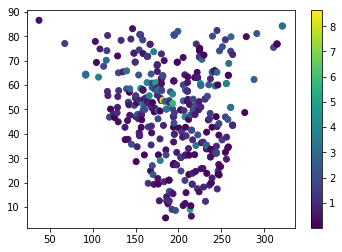

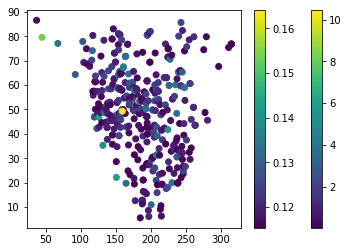

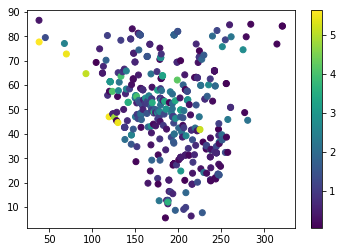

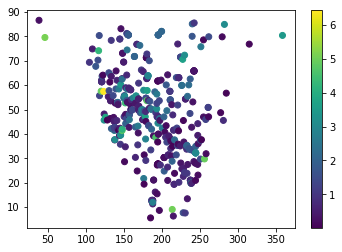

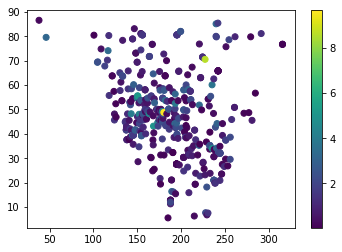

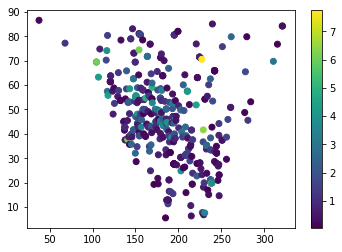

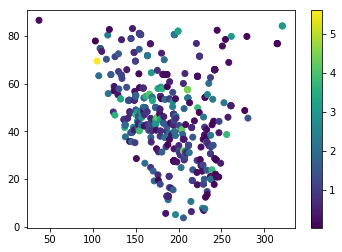

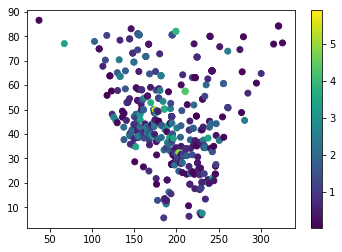

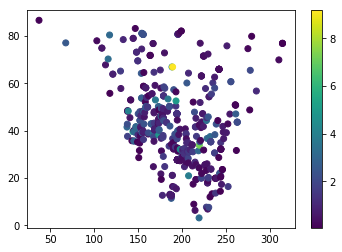

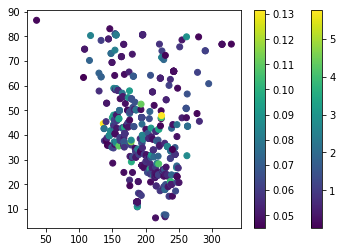

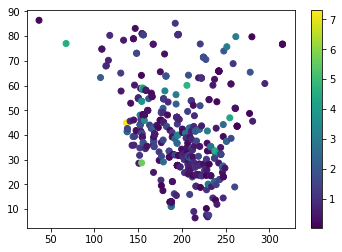

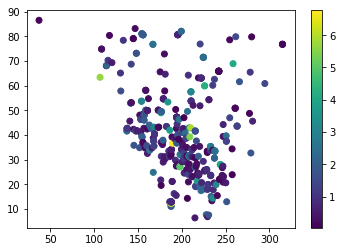

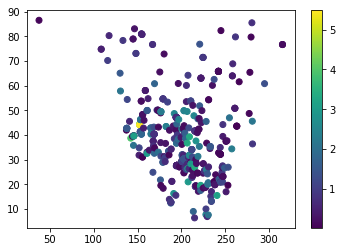

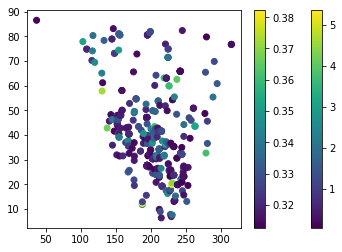

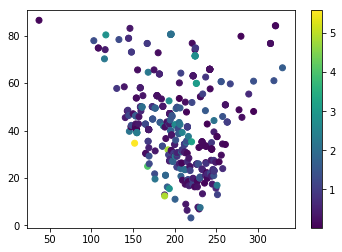

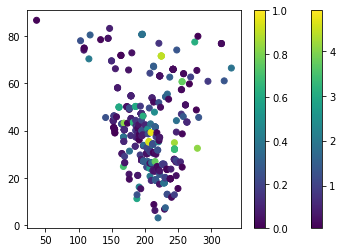

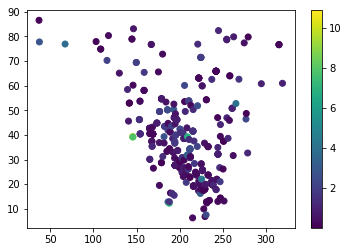

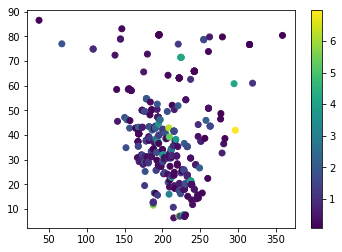

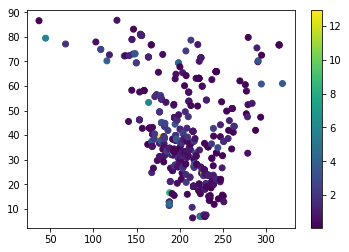

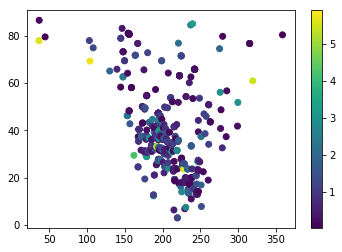

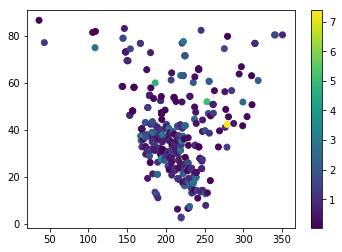

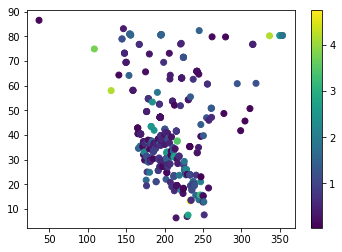

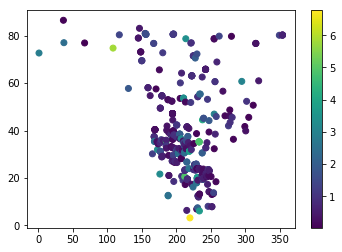

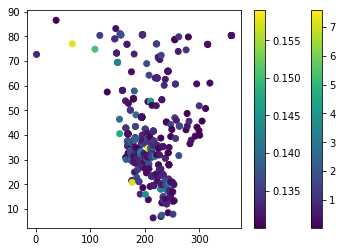

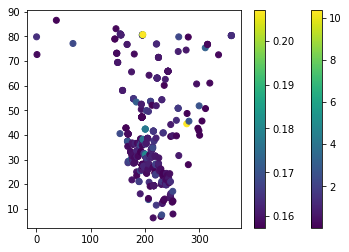

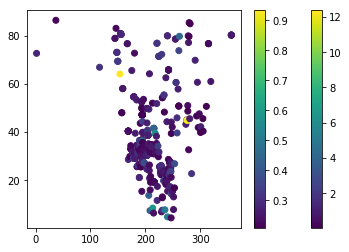

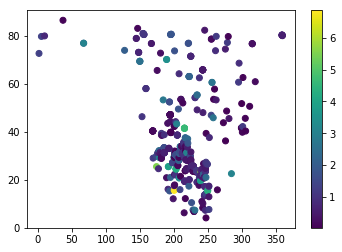

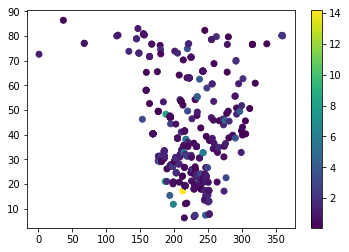

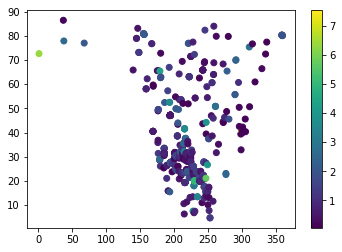

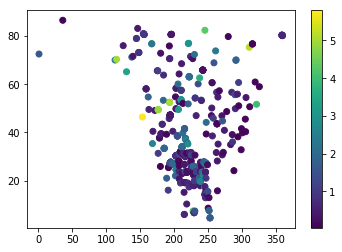

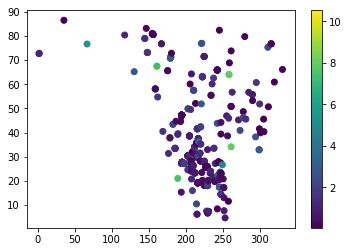

In [124]:

for frame in np.unique(tot_df.frame):
    plt.figure(frame)
    
    plt.scatter(tot_df[tot_df.frame == frame].ra,
                tot_df[tot_df.frame == frame].decl,
                c = np.abs(tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg))
    plt.colorbar()

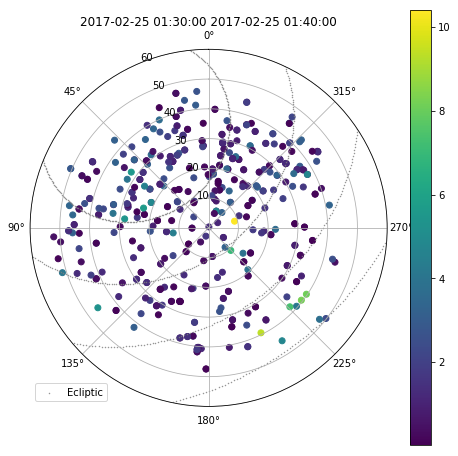

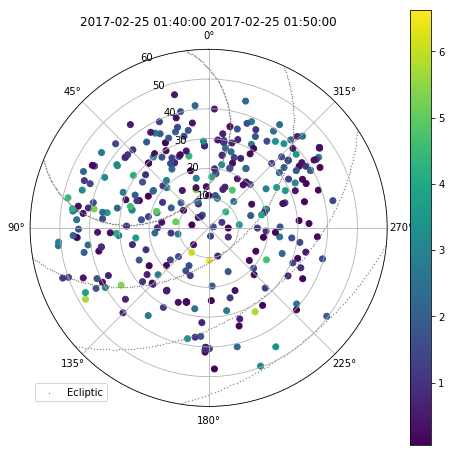

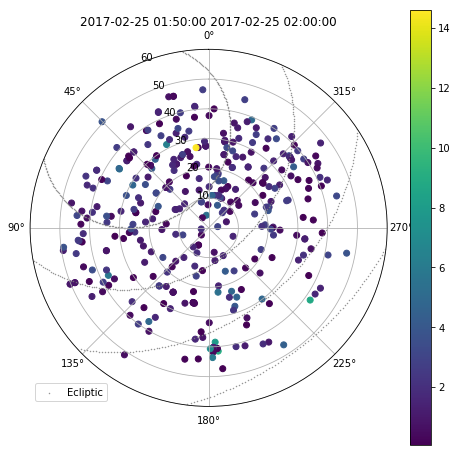

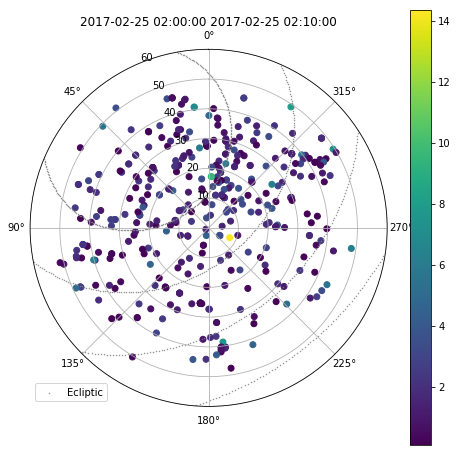

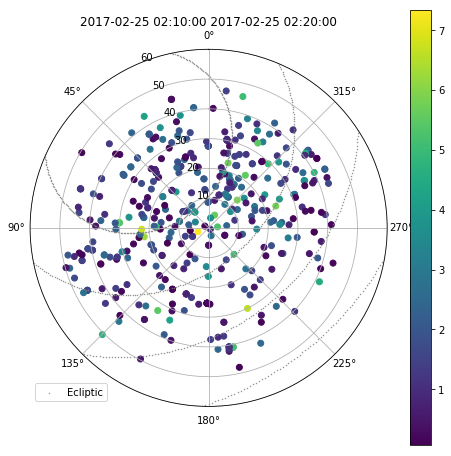

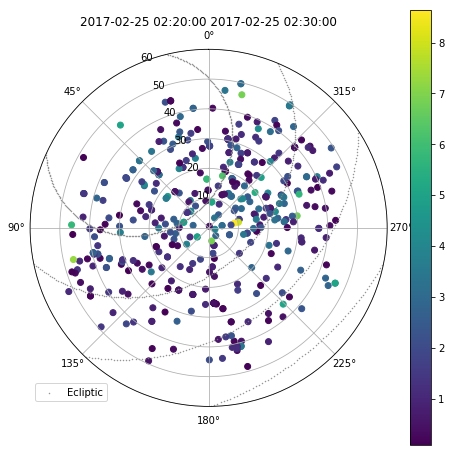

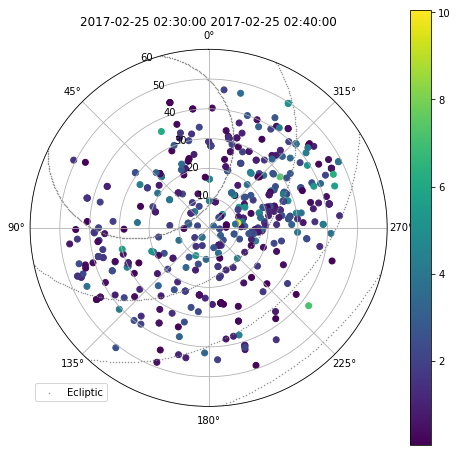

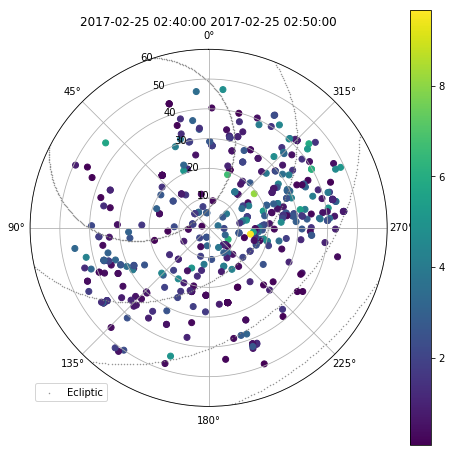

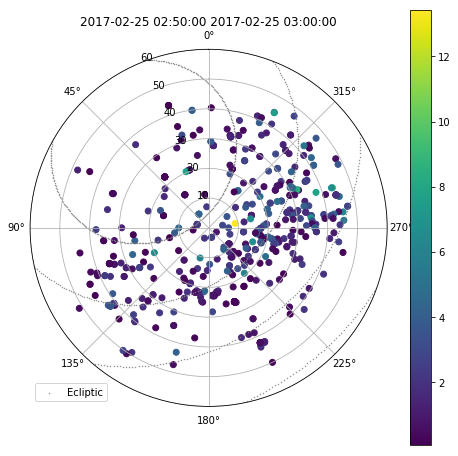

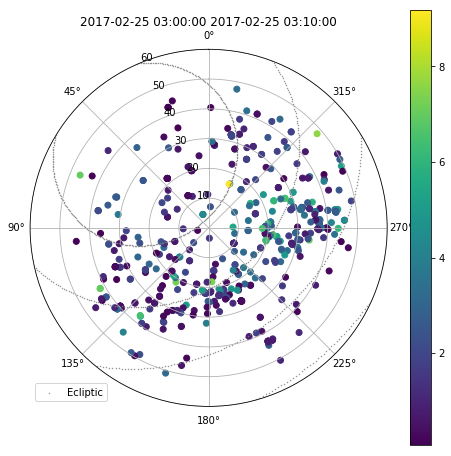

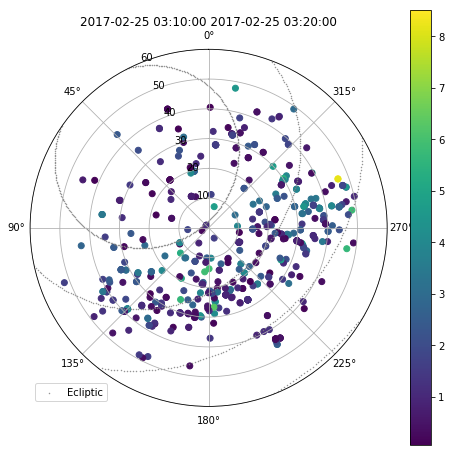

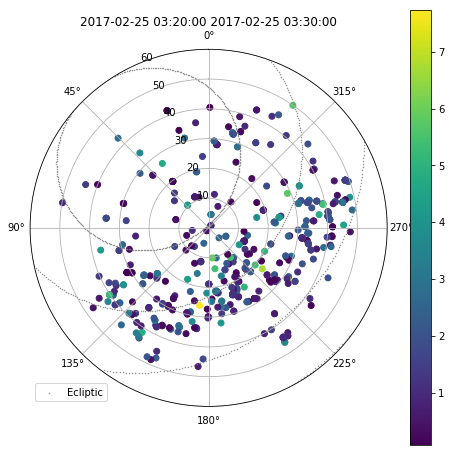

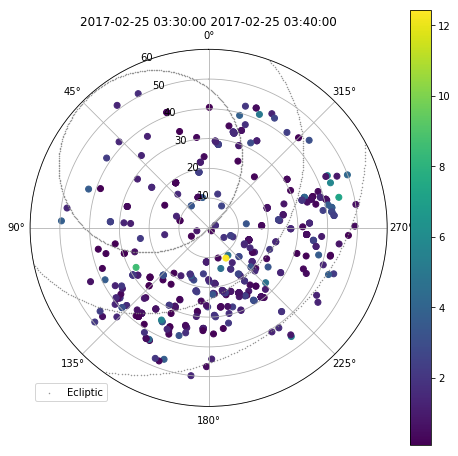

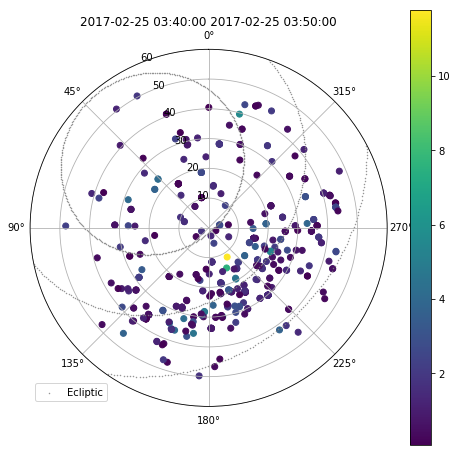

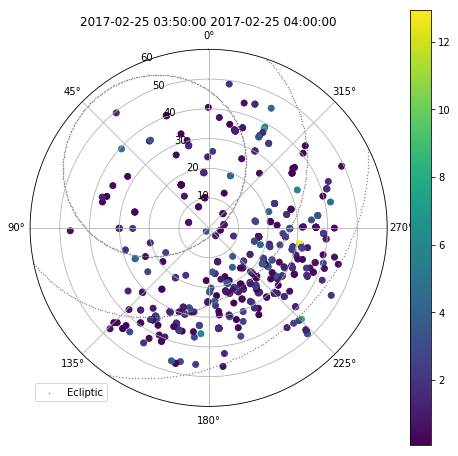

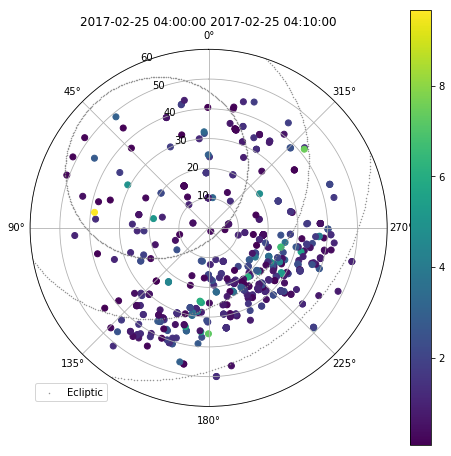

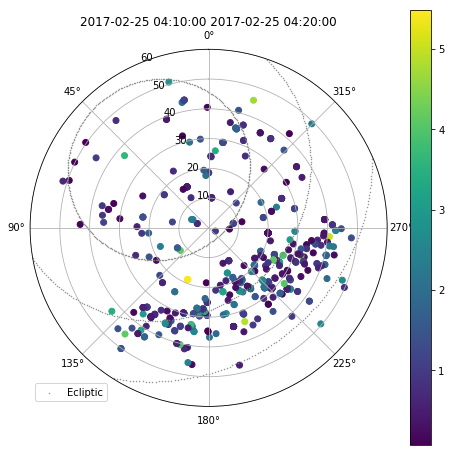

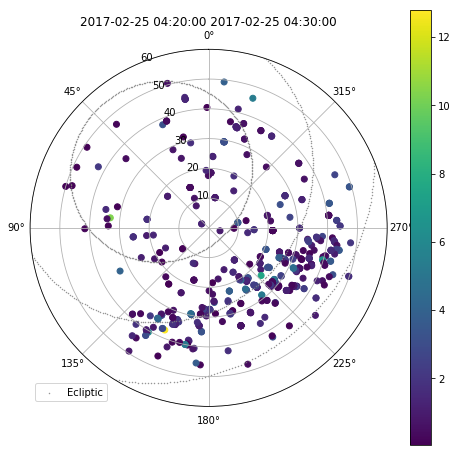

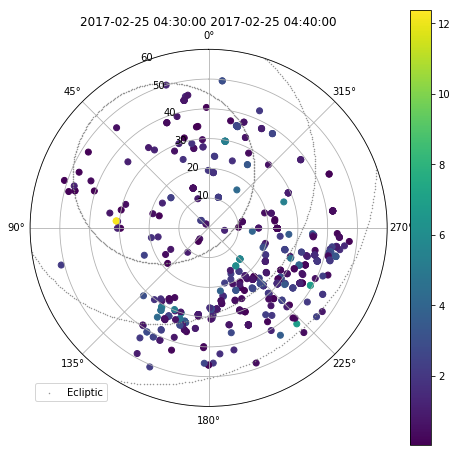

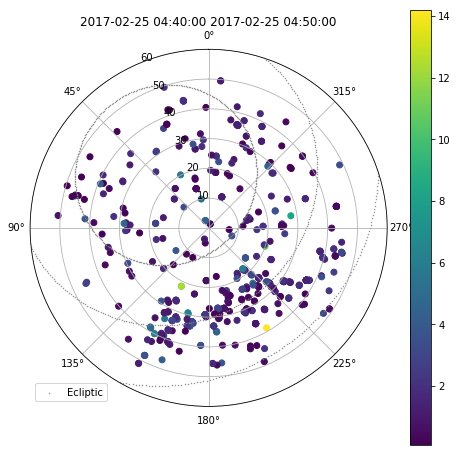

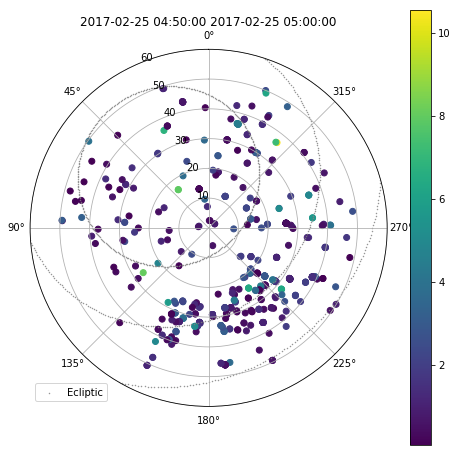

In [49]:
CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')

# times =  pd.date_range(start='2017-02-25 01:30:00', end="2017-02-25 05:00:00",  freq="300s")

tot_df = tot_df.groupby("ra").mean().reset_index()
n=0
for frame in np.unique(tot_df.frame):

    list_ra = [x*u.degree for x in tot_df[tot_df.frame == frame].ra]
    list_decl = [x*u.degree for x in tot_df[tot_df.frame == frame].decl]

    position = SkyCoord(list_ra, list_decl)


    obs_times = [times[int(frame)]] 


    altaz = position.transform_to(AltAz(obstime=obs_times* len(list_ra), location=CS002))
    
    ecliptic = SkyCoord(np.concatenate([np.linspace(0,360,360),
                                   np.linspace(0,360,360),
                                   np.linspace(0,360,360),
                                   np.linspace(0,360,360) ]), 
                        np.concatenate([np.zeros(360),
                                   20*np.ones(360),
                                   40*np.ones(360),
                                   60*np.ones(360)]), 
                        unit="deg", 
                        frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times* 4*360, location=CS002))

    
    plt.figure(frame, figsize=(8,8))
    ax = plt.subplot(projection="polar")
    plt.scatter( altaz.az.rad, 
                (90-altaz.alt.deg), 
                c=np.abs(tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg))

    plt.colorbar()
#     plt.scatter( ecliptic.az.rad,(90-ecliptic.alt.deg), s=1)
    ax.set_theta_zero_location("N")

    plt.scatter(ecliptic.az.rad, 
                (90-ecliptic.alt.deg),c="grey", s=0.2, label="Ecliptic")

    grid_x, grid_y = np.mgrid[-50:50:100j, -50:50:100j]

    plt.imshow(griddata(zip(pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0],
           -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]),
        tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg,
        (grid_x, grid_y ), method="linear"), origin="lower" )
    
    plt.title(str(times[int(n)])+" "+str(times[int(n)+1]))
    plt.legend(loc="lower left")
#     plt.xlim([0,110])
    plt.ylim([0,60])
    plt.savefig("/home/kuiack/modindex/{}.png".format(str(n).zfill(3)))
    plt.show()
    n+=1

(-55, 55)

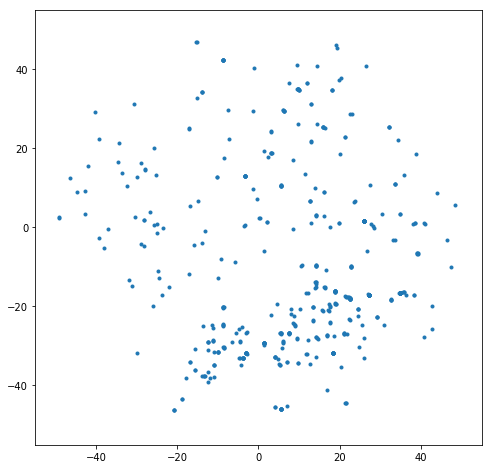

In [57]:
plt.figure(figsize=(8,8))
plt.plot(x,y,".")
plt.xlim([-55,55])
plt.ylim([-55,55])

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st

aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")


CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')

# times =  pd.date_range(start='2017-02-25 01:30:00', end="2017-02-25 05:00:00",  freq="300s")

tot_df = tot_df.groupby("ra").mean().reset_index()
n=0
for frame in np.unique(tot_df[tot_df.frame % 1.0 == 0].frame):
#     print frame
    list_ra = [x*u.degree for x in tot_df[tot_df.frame == frame].ra]
    list_decl = [x*u.degree for x in tot_df[tot_df.frame == frame].decl]

    position = SkyCoord(list_ra, list_decl)


    obs_times = [times[int(frame)]] 


    altaz = position.transform_to(AltAz(obstime=obs_times* len(list_ra), location=CS002))
    AART_altaz = SkyCoord(aart.ra.values*u.deg, 
                          aart.decl.values*u.deg).transform_to(AltAz(obstime=obs_times*len(aart.ra),
                                                                 location=CS002))
    
    
    ecliptic = SkyCoord(np.concatenate([np.linspace(-180,180,360),
                               np.linspace(-180,180,360),
                               np.linspace(-180,180,360),
                               np.linspace(-180,180,360) ]), 
                    np.concatenate([np.zeros(360),
                               20*np.ones(360),
                               40*np.ones(360),
                               60*np.ones(360)]), 
                    unit="deg", 
                    frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times* 4*360, location=CS002))

    text_ecliptic = SkyCoord([180,180,180,180],[0,20,40,60],unit="deg", 
                             frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times*4, location=CS002))
    
    
    text_ecliptic_x = -pol2cart((90-text_ecliptic.alt.deg), text_ecliptic.az.rad,)[1]
    text_ecliptic_y = pol2cart((90-text_ecliptic.alt.deg), text_ecliptic.az.rad,)[0]
    
    AltAz_x = -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]
    AltAz_y = pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0]
    
    aart_x = -pol2cart((90-AART_altaz.alt.deg), AART_altaz.az.rad,)[1]
    aart_y = pol2cart((90-AART_altaz.alt.deg), AART_altaz.az.rad,)[0]

    ecliptic_x = -pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[1]
    ecliptic_y = pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[0]
    
    AltAz_x, AltAz_y = AltAz_x[(np.sqrt(AltAz_x**2. + AltAz_y**2.) < 55)], AltAz_y[(np.sqrt(AltAz_x**2. + AltAz_y**2.) < 55)]
    
    aart_x, aart_y = aart_x[(np.sqrt(aart_x**2. + aart_y**2.) < 55)], aart_y[(np.sqrt(aart_x**2. + aart_y**2.) < 55)]
    
    ecliptic_x, ecliptic_y = ecliptic_x[(np.sqrt(ecliptic_x**2. + ecliptic_y**2.) < 55)], ecliptic_y[(np.sqrt(ecliptic_x**2. + ecliptic_y**2.) < 55)]  
    
    xmin, xmax = -55, 55
    ymin, ymax = -55, 55

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([AltAz_x, AltAz_y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    ax.plot(AltAz_x, AltAz_y,".")
    
    ax.scatter(ecliptic_x, ecliptic_y,
               c="grey", s=0.2, label="Ecliptic")
    
    ax.plot(-pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[1],
            pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[0],"r")
    

    
    for t_x, t_y, t_s in zip(text_ecliptic_x,text_ecliptic_y,['0','20','40','60']) :
        ax.text(t_x,t_y,t_s, zorder=999)
    

    ax.scatter(aart_x, aart_y, marker="o",
               c="orange", s=50, label="AARTFAAC", zorder=999)
    
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    # Contourf plot
    cfset = ax.contourf(xx, yy, f, [2e-4,3e-4,4e-4,6e-4, 1e-3 ], cmap='Blues')

    # Contour plot
    cset = ax.contour(xx, yy, f, [2e-4, 3e-4, 4e-4, 6e-4, 1e-3 ], colors='k')
    # Label plot
#     ax.clabel(cset, inline=1, fontsize=10)

    plt.title(str(times[int(n)])+" "+str(times[int(n)+1]))

    plt.legend(loc="lower left")
    plt.savefig("/home/kuiack/modindex/20180309_{}.png".format(str(n).zfill(3)))
    n+=1
    plt.show()

In [132]:
np.unique(tot_df[tot_df.frame % 1.0 == 0].frame)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.])

In [129]:
[x*u.degree for x in tot_df[tot_df.frame == 6].ra]

[<Quantity 16.58750087317924 deg>,
 <Quantity 37.99990053481839 deg>,
 <Quantity 63.76124610275692 deg>,
 <Quantity 68.11779700082397 deg>,
 <Quantity 68.13171166512035 deg>,
 <Quantity 87.4257968535142 deg>,
 <Quantity 92.8631647737995 deg>,
 <Quantity 102.95781533641066 deg>,
 <Quantity 104.4306512024987 deg>,
 <Quantity 104.43529476591715 deg>,
 <Quantity 104.43768517583322 deg>,
 <Quantity 104.44894785981627 deg>,
 <Quantity 105.41757975566875 deg>,
 <Quantity 106.18369963976599 deg>,
 <Quantity 106.93683786276898 deg>,
 <Quantity 107.450781031973 deg>,
 <Quantity 108.57205565796517 deg>,
 <Quantity 108.57998771832534 deg>,
 <Quantity 110.515317947773 deg>,
 <Quantity 115.45984178312635 deg>,
 <Quantity 115.77329157176625 deg>,
 <Quantity 115.96394317306205 deg>,
 <Quantity 116.6540611020504 deg>,
 <Quantity 117.55668953861822 deg>,
 <Quantity 117.80600942586851 deg>,
 <Quantity 117.98688997283162 deg>,
 <Quantity 118.13165268532049 deg>,
 <Quantity 118.17589779934967 deg>,
 <Quant

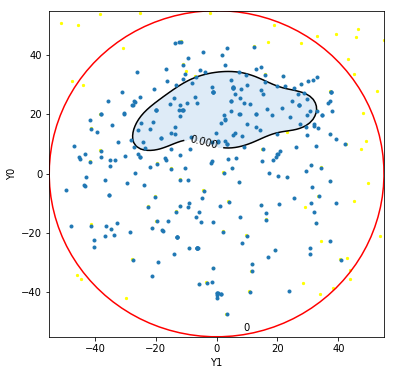

In [152]:
import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st

# data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
# x = data[:, 0]
# y = data[:, 1]
# xmin, xmax = -3, 3
# ymin, ymax = -3, 3

x = -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]
y = pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0]
xmin, xmax = -55, 55
ymin, ymax = -55, 55

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = pl.figure(figsize=(6,6))
ax = fig.gca()
ax.plot(x,y,".")
ax.plot(-pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[1],
        pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[0],"r")

ax.scatter(aart_x, aart_y, marker="o",
           c="yellow", s=5, label="aart")


ax.text(ecliptic_x[180],ecliptic_y[180],'0')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, [2e-4,3e-4,4e-4, 6e-4 ], cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, [2e-4,3e-4,4e-4,5e-4 ], colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

pl.show()

In [109]:
cfset

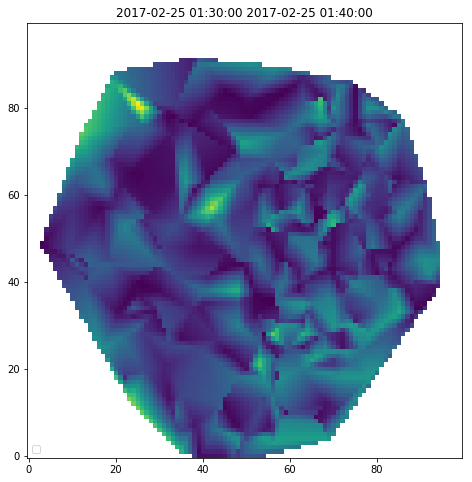

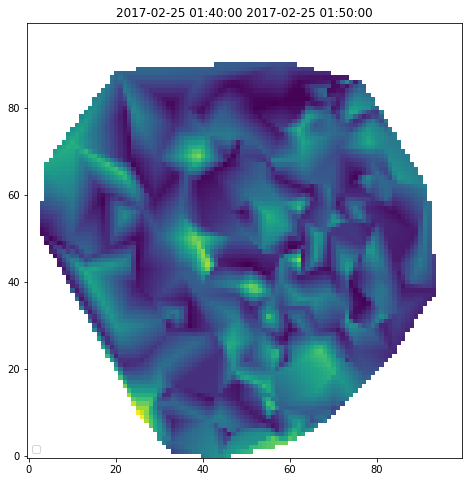

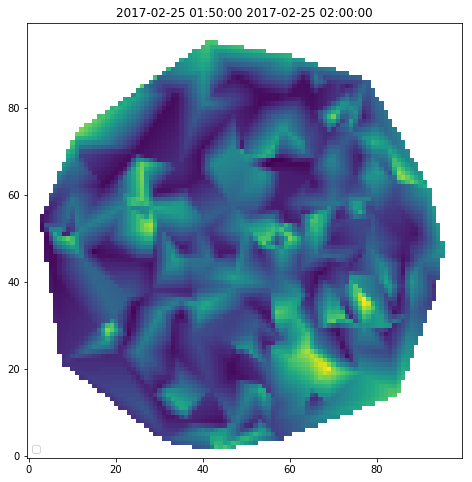

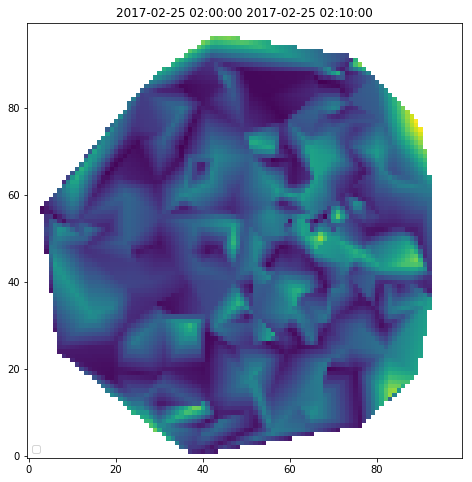

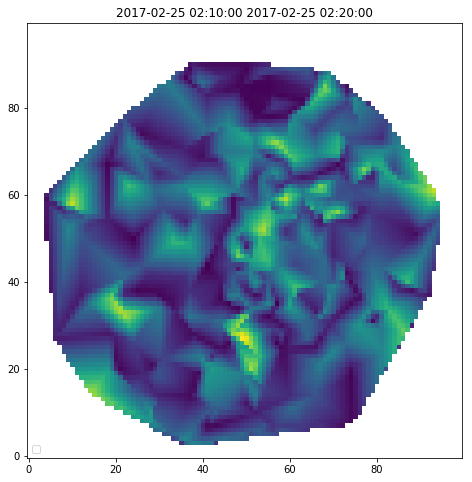

In [42]:
CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')

# times =  pd.date_range(start='2017-02-25 01:30:00', end="2017-02-25 05:00:00",  freq="300s")

tot_df = tot_df.groupby("ra").mean().reset_index()
n=0
for frame in np.unique(tot_df.frame):

    list_ra = [x*u.degree for x in tot_df[tot_df.frame == frame].ra]
    list_decl = [x*u.degree for x in tot_df[tot_df.frame == frame].decl]

    position = SkyCoord(list_ra, list_decl)


    obs_times = [times[int(frame)]] 


    altaz = position.transform_to(AltAz(obstime=obs_times* len(list_ra), location=CS002))
    ecliptic = SkyCoord(np.concatenate([np.linspace(0,360,360),
                                   np.linspace(0,360,360),
                                   np.linspace(0,360,360),
                                   np.linspace(0,360,360) ]), 
                        np.concatenate([np.zeros(360),
                                   20*np.ones(360),
                                   40*np.ones(360),
                                   60*np.ones(360)]), 
                        unit="deg", 
                        frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times* 4*360, location=CS002))

    
    plt.figure(frame, figsize=(8,8))

    grid_x, grid_y = np.mgrid[-50:50:100j, -50:50:100j]
    x = -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]
    y = pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0]
    
    
    plt.imshow(griddata(zip(x, y),
        np.abs(tot_df[tot_df.frame == frame].f_std/(tot_df[tot_df.frame == frame].f_avg+0.1)),
        (grid_x, grid_y ), method="linear"), origin="lower" )
    
    plt.title(str(times[int(n)])+" "+str(times[int(n)+1]))
    plt.legend(loc="lower left")
#     plt.xlim([0,110])

#     plt.savefig("/home/kuiack/modindex/{}.png".format(str(n).zfill(3)))
    plt.show()
    n+=1

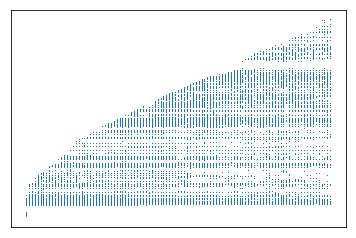

In [37]:
plt.xticks([]);plt.yticks([])
plt.plot(tot_df.frame,tot_df.runcat, ",")

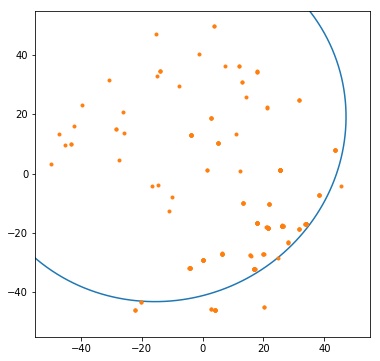

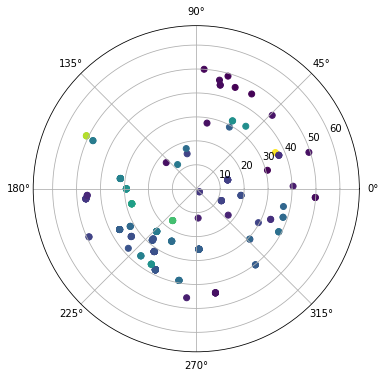

In [98]:
plt.figure(figsize=(6,6))

plt.plot(-pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[1],
       pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[0])

plt.plot(pol2cart(-(90-altaz.alt.deg), altaz.az.rad,)[1],
           pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0], ".")
plt.xlim([-55,55])
plt.ylim([-55,55])


plt.figure(frame, figsize=(6,6))
ax = plt.subplot(projection="polar")
plt.scatter( altaz.az.rad,(90-altaz.alt.deg) ,c=tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg)




# ax.set_theta_zero_location("N")

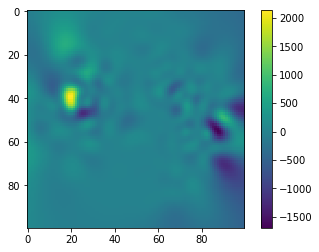

In [23]:



from scipy.interpolate import Rbf

grid_x, grid_y = np.mgrid[-50:50:100j, -50:50:100j]

x = -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]
y = pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0]

z = np.abs(tot_df[tot_df.frame == frame].f_std/(tot_df[tot_df.frame == frame].f_avg+0.1))


rbfi = Rbf(x,y,z, epsilon=10)
plt.imshow(rbfi(grid_x, grid_y))
plt.colorbar()


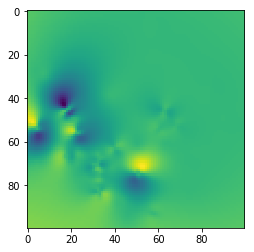

In [14]:
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib import pyplot as pp

# kernel density estimate of the PDF
kde = gaussian_kde(points)

# evaluate the estimated PDF on a grid
x,y = np.mgrid[40:101,-20:101]
z = kde((x.ravel(),y.ravel())).reshape(*x.shape)

# plot
fig,ax = pp.subplots(1,1)
ax.hold(True)
pc = ax.pcolor(x,y,z)
cb = pp.colorbar(pc)
cb.ax.set_ylabel('Probability density')
ax.plot(points[0],points[1],'o',mfc='w',mec='k')

pp.show()

NameError: name 'points' is not defined

In [20]:
from scipy.interpolate import Rbf
x, y, z, d = np.random.rand(4, 50)
rbfi = Rbf(x, y, z, d)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di = rbfi(xi, yi, zi)   # interpolated values
di

array([ 0.39945272,  0.31784025,  0.26831797,  0.26253208,  0.30194697,
        0.38630496,  0.49998022,  0.5787986 ,  0.5749488 ,  0.55123067,
        0.62579546,  0.80333292,  0.943337  ,  0.91059554,  0.7226246 ,
        0.53134228,  0.44949034,  0.44231203,  0.43369643,  0.40557339])

In [48]:
tot_df.groupby("ra").mean().reset_index()

ra       decl      f_avg      f_std  frame  runcat
0       1.277813  72.752417  32.495889   5.500668    9.0  2303.0
1       1.474913  72.593942  29.498290   3.219502   10.0  2303.0
2      36.190534  86.427415  28.348781   3.981841   10.0   186.0
3      36.498832  86.460234  30.166763   3.696197    9.0   186.0
4      36.701270  86.497203  32.923523   3.010416    5.0   186.0
5      36.757217  86.525033  32.276096   2.334746    7.0   186.0
6      36.855405  86.515476  32.324998   2.480397    6.0   186.0
7      36.967198  86.519618  29.815921   2.706066    8.0   186.0
8      37.504488  86.537809  35.348389  10.999523    3.0   186.0
9      37.874164  86.541624  33.106410   6.766020    4.0   186.0
10     37.934229  86.529741  35.271743  10.128139    2.0   186.0
11     38.076645  86.540347  33.237449  10.390577    1.0   186.0
12     38.593557  86.539149  36.737462  12.923271    0.0   186.0
13     40.763159  79.997629  22.446319   3.656440    9.0  2478.0
14     67.147890  76.881014  24.152490   2.291981   10.0  1704.5
15     67.148567  76.881400  24.155099   2.292264   10.0   230.0
16     67.233841  76.981965  21.188753   2.700077    9.0  2497.0
17     67.251576  76.985868  21.136219   2.748602    9.0   912.0
18     67.254196  76.986665  21.125604   2.744822    9.0   230.0
19    103.093622  77.905641  13.563323   5.408668    6.0   228.0
20    104.448008  69.262859  17.145963   4.284403    2.0   211.0
21    104.576717  53.993732  34.479332  12.811160    1.0   395.5
22    104.578068  53.993412  34.480757  12.800634    1.0   541.0
23    104.610486  54.015724  33.046050  10.981704    1.0   713.0
24    104.630809  54.084593  28.923359   9.811608    0.0   209.0
25    106.847505  63.300637  17.365638  11.642016    0.0   168.0
26    106.879828  63.282378  16.740860   5.241159    1.0   168.0
27    106.898004  63.291083  13.921556   4.977512    2.0   168.0
28    108.486763  74.848498  16.644760   4.078391    7.0  1574.0
29    108.488008  74.830228  19.295834   4.086129    6.0  1574.0
...          ...        ...        ...        ...    ...     ...
2113  315.065076  76.717139  16.218744   4.616950    8.0   715.0
2114  315.070096  76.729016  16.217462   4.618003    8.0   196.0
2115  315.077625  76.838503  32.024791   6.654183    0.0   196.0
2116  315.093449  76.716236  20.534039   4.207152    6.0   682.0
2117  315.094483  76.715550  20.536678   4.204422    6.0   715.0
2118  315.101319  76.722820  20.518712   4.222863    6.0   196.0
2119  315.144167  76.699405  19.576590   5.502179    7.0   682.0
2120  315.145226  76.698769  19.570869   5.507694    7.0   715.0
2121  315.149275  76.705476  19.657791   5.388842    7.0   196.0
2122  315.150971  76.667507  22.938590   5.024783   10.0   682.0
2123  315.151532  76.667214  22.932319   5.041811   10.0   715.0
2124  315.151605  76.670336  22.980041   4.927937   10.0   196.0
2125  315.168803  76.724753  27.320613   2.948946    4.0   682.0
2126  315.168853  76.724709  27.320613   2.948946    4.0   715.0
2127  315.169706  76.725164  27.321717   2.946733    4.0   196.0
2128  319.243568  61.002741  32.161143   2.983032    7.0  1927.0
2129  319.259525  61.008575  34.264320   3.951552    6.0  1927.0
2130  319.260004  60.928184  30.652679   3.131368    8.0  1927.0
2131  319.283655  60.923247  33.543348   3.967015   10.0  1927.0
2132  319.345815  60.923826  31.401660   4.213874    9.0  1927.0
2133  321.388534  84.150015  16.212228   4.450748    1.0   309.0
2134  326.104792  80.372977  21.578306   2.150344    2.0  1039.0
2135  333.381144  80.367168  21.520143   2.052085    2.0   507.0
2136  334.822388  80.368729  21.506900   2.046491    2.0   308.0
2137  346.425967  80.202954  22.142882   3.568784    9.0  1520.0
2138  348.750675  80.275663  22.043805   3.601128    9.0  1056.0
2139  349.165087  80.283910  22.020332   3.609867    9.0  1039.0
2140  349.169945  80.292733  22.014859   3.636515    9.0   308.0
2141  349.180973  80.290385  22.022786   3.635889    9.0   507.0
2142  354.998908  80.363511  21.405974   7.689766

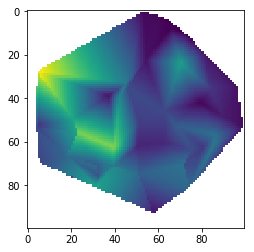

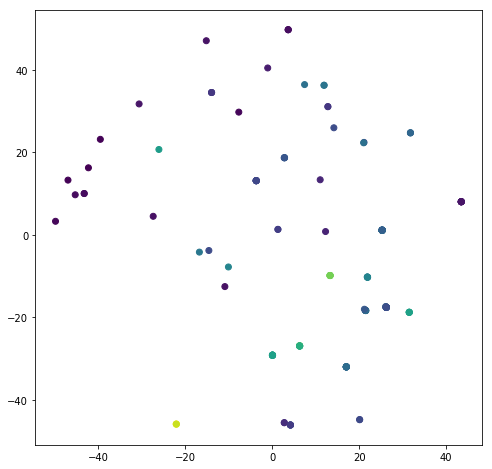

In [94]:
plt.figure(figsize=(8,8))
plt.scatter(-pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1],
           pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0],
           c=tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg)

In [90]:
skip = 10
roll = 1

#here 
survey_out = pd.DataFrame([])
for i in glob.glob("/data/survey/aart*-positions.csv"):
    survey_out = pd.concat([survey_out, 
                            pd.read_csv(i) ], ignore_index=True)
# survey_out = pd.read_csv("/home/kuiack/aart0_positions.csv")

# survey_out.taustart_ts = pd.to_datetime(pd.to_datetime(pd.read_csv(i).taustart_ts)\
#                .astype(int).rolling(roll, center=True).mean())

survey_out = survey_out[::skip]

vlssr = pd.read_csv("/home/kuiack/VLSSr.tsv", 
                    delimiter="\t", comment="#")

vlssr = vlssr[(vlssr.Sp > 30)]
# print len(aart), len(vlssr[(vlssr.Sp > 20)])

# calculate a histogram of the area/sensitivity for timesteps from the TraP database
CS002 = EarthLocation.from_geocentric (3826577.1095, 461022.900196, 5064892.758, 'm')


position = SkyCoord(survey_out.ra.values*u.degree,
                    survey_out.decl.values*u.degree, unit=(u.deg, u.deg),
#                     obstime=[Time(i,scale='utc') for i in survey_out.taustart_ts],
                    location=CS002, frame="fk5")

vlssr_coord = SkyCoord(vlssr._RAJ2000.values*u.degree,
                       vlssr._DEJ2000.values*u.degree)

print len(position), len(vlssr_coord)


48325 129


In [91]:
# catalogue matching 
idxc, idxcatalog, d2d, d3d = position.search_around_sky(vlssr_coord, 1.*u.deg)
AART_pos =  position[idxcatalog]
vlssr_pos = vlssr_coord[idxc]

print len(idxcatalog), len(idxc)
# idxc, idxcatalog, d2d, d3d = vlssr_coord.search_around_sky(position, 1*u.deg)
# AART_pos =  position[idxc]
# vlssr_pos = vlssr_coord[idxcatalog]


obstime = survey_out.iloc[idxcatalog].taustart_ts


print len(AART_pos), len(vlssr_pos), len(obstime)

24341 24341
24341 24341 24341


<IPython.core.display.Javascript object>


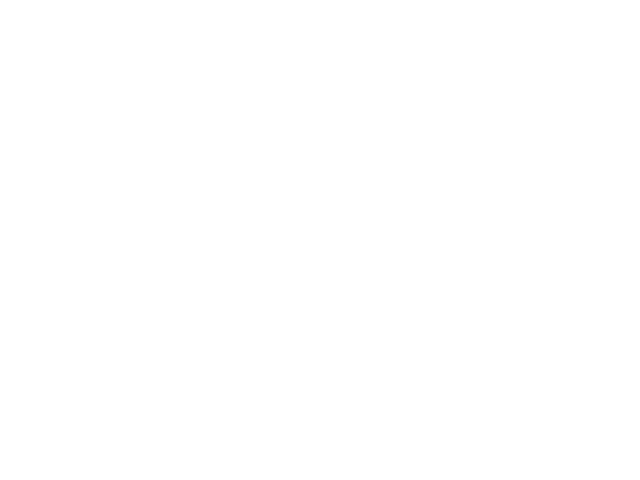

0.249576811797 0.254940940792


<IPython.core.display.Javascript object>


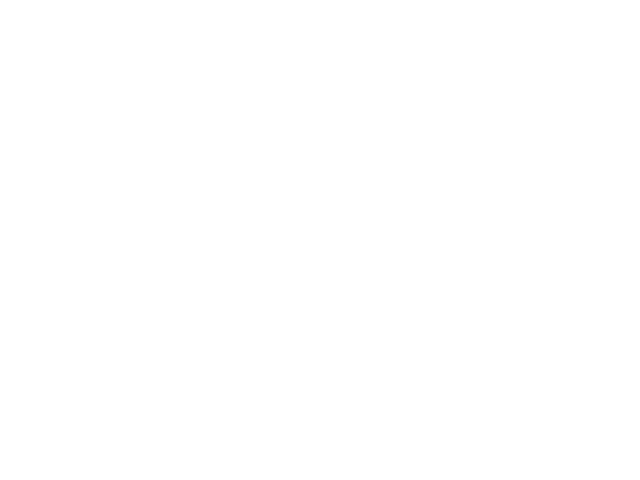

In [92]:
plt.figure()
plt.hist( d2d.deg, bins=100)
plt.xlabel("AARTFAAC VLSSr seperation [deg]")

print np.mean(d2d.deg), np.median(d2d.deg)

plt.figure()
plt.plot(AART_pos.ra.deg, 
         AART_pos.dec.deg, ".")

plt.plot(vlssr_pos.ra.deg, 
         vlssr_pos.dec.deg, ".")

In [93]:
%%time

aart_altaz = AART_pos.transform_to(AltAz(obstime=[Time(x, scale="utc", format="iso")\
                                                  for x in obstime ],
                                         location=CS002))

vlssr_altaz = vlssr_pos.transform_to(AltAz(obstime=[Time(x, scale="utc", format="iso")\
                                                    for x in obstime ],
                                           location=CS002))

CPU times: user 52.6 s, sys: 496 ms, total: 53.1 s
Wall time: 52.9 s


In [94]:
def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


sr_y, sr_x = pol2cart(np.abs(90.-np.array(aart_altaz.alt.deg)), aart_altaz.az.rad)
vlssr_sr_y, vlssr_sr_x = pol2cart(np.abs(90 - vlssr_altaz.alt.deg),vlssr_altaz.az.rad)


<IPython.core.display.Javascript object>


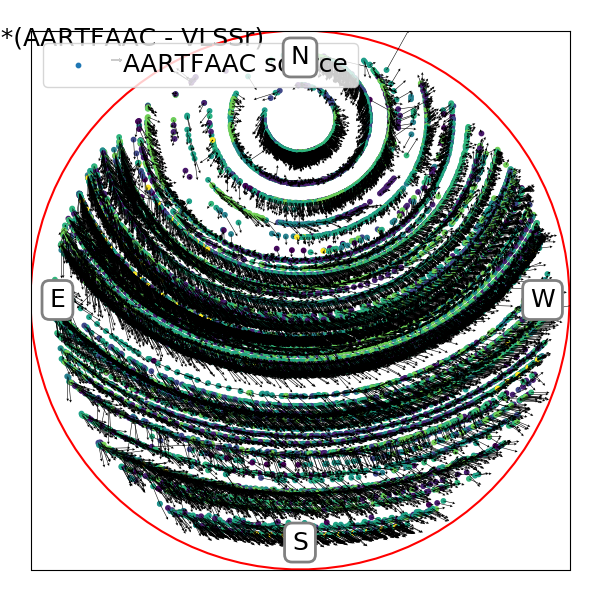

In [95]:
%matplotlib notebook

plt.figure(figsize=(6,6))

plt.plot(-pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[1],
        pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[0],"r",zorder=0)


plt.scatter(sr_x, sr_y,  s=10, label="AARTFAAC source",
            c=pd.to_datetime(obstime))#,c="orange",  )

Q = plt.quiver(sr_x, sr_y,
           sr_x-vlssr_sr_x.ravel(), sr_y-vlssr_sr_y.ravel(), headwidth=5,
               angles='xy', scale_units='xy', scale=0.1, width=0.001)

plt.quiverkey(Q,  0.16 , 0.945, 1, label="20*(AARTFAAC - VLSSr)")




bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=2)

plt.annotate("S", (0.0,0.3), xytext=(0.5,0.05), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("N", (0.0,0.3), xytext=(0.5,0.95),  zorder=99,
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   

plt.annotate("W", (0.0,0.3), xytext=(0.95,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("E", (0.0,0.3), xytext=(0.05,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")    
    

# plt.colorbar()
plt.xlim([-55, 55])
plt.ylim([-55, 55])
plt.xticks([])
plt.yticks([])
plt.legend()
plt.tight_layout()
# plt.savefig("/home/kuiack/mag_figs/scintel_mag_v_vlssr.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.savefig("/home/kuiack/surveyfigs/position_offset_large.pdf", bbox_inches = 'tight' )



In [96]:
grid_x, grid_y = np.mgrid[-55:55:45j, -55:55:45j]

points = zip(sr_x, sr_y)

U_values = sr_x-vlssr_sr_x
V_values = sr_y-vlssr_sr_y

grid_zU = griddata(points, U_values, (grid_x, grid_y), method='linear')
grid_zV = griddata(points, V_values, (grid_x, grid_y), method='linear')

# from scipy.interpolate import griddata
# grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
# grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
# grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

<IPython.core.display.Javascript object>


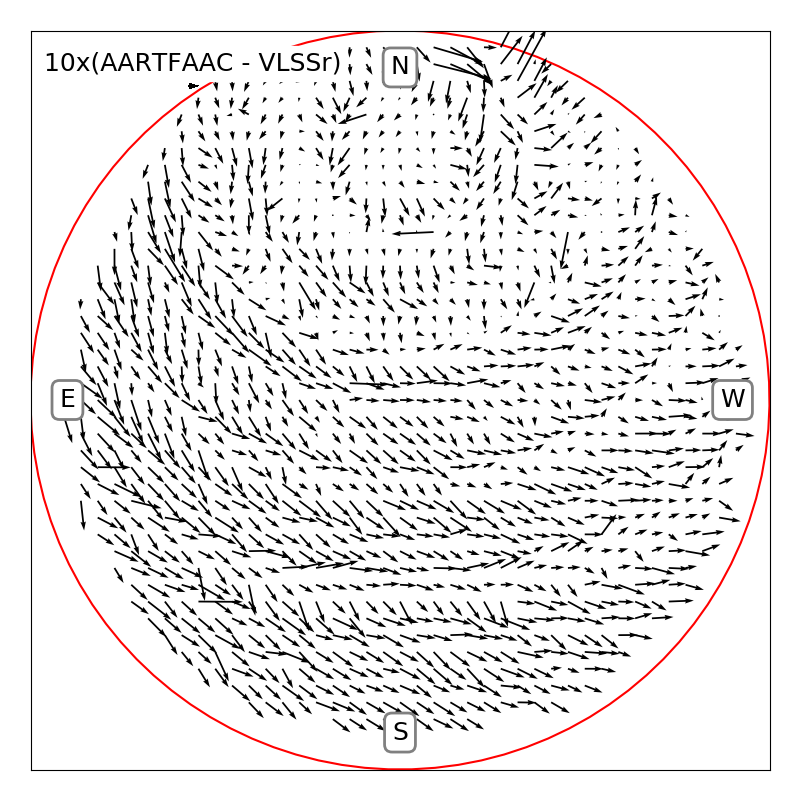

In [98]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,8))

plt.plot(-pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[1],
        pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[0],"r",zorder=0)

_ind = [(np.sqrt(grid_x**2.+grid_y**2.) < 55)]


scale = 0.1
Q = plt.quiver(grid_x[_ind], grid_y[_ind], grid_zU[_ind], grid_zV[_ind],# headwidth=6, width=0.0015,headlength=7,
               angles='xy', scale_units='xy', scale=scale)

Qk = plt.quiverkey(Q,  0.22 , 0.925, 1, 
              label="{}x(AARTFAAC - VLSSr)".format(int(1./scale)))

Qk.text.set_backgroundcolor('w')

bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=2)

plt.annotate("S", (0.0,0.3), xytext=(0.5,0.05), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("N", (0.0,0.3), xytext=(0.5,0.95),  zorder=99,
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   

plt.annotate("W", (0.0,0.3), xytext=(0.95,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("E", (0.0,0.3), xytext=(0.05,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")    

plt.xlim([-55,55])
plt.ylim([-55,55])
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig("/home/kuiack/surveyfigs/position_offset_interp.pdf", bbox_inches = 'tight' )


In [58]:
skip = 1
roll = 1

#here 
survey_out = pd.DataFrame([])
for i in glob.glob("/home/kuiack/aart*-positions.csv"):
    survey_out = pd.concat([survey_out, 
                            pd.read_csv(i) ], ignore_index=True)
# survey_out = pd.read_csv("/home/kuiack/aart0_positions.csv")

# survey_out.taustart_ts = pd.to_datetime(pd.to_datetime(pd.read_csv(i).taustart_ts)\
#                .astype(int).rolling(roll, center=True).mean())

survey_out = survey_out[::skip]

# vlssr = pd.read_csv("/home/kuiack/VLSSr.tsv", 
#                     delimiter="\t", comment="#")

# vlssr = vlssr[(vlssr.Sp > 30)]

# calculate a histogram of the area/sensitivity for timesteps from the TraP database
# CS002 = EarthLocation.from_geocentric (3826577.1095, 461022.900196, 5064892.758, 'm')


# position = SkyCoord(survey_out.ra.values*u.degree,
#                     survey_out.decl.values*u.degree, unit=(u.deg, u.deg),
# #                     obstime=[Time(i,scale='utc') for i in survey_out.taustart_ts],
#                     location=CS002, frame="fk5")

# vlssr_coord = SkyCoord(vlssr._RAJ2000.values*u.degree,
#                        vlssr._DEJ2000.values*u.degree)

print len(position), len(vlssr_coord)


483247 129


In [73]:
_n = []
_ra_std = []
_dec_std = []
_dec = []
_ra = []

for _ID in np.unique(survey_out.id):
    _ra.append(survey_out[survey_out.id == _ID].ra.mean())
    _dec.append(survey_out[survey_out.id == _ID].decl.mean())
    _n.append(len(survey_out[survey_out.id == _ID]))
    _ra_std.append(survey_out[survey_out.id == _ID].ra.std()),
    _dec_std.append(survey_out[survey_out.id == _ID].decl.std())
    
    
    
    

db       decl  id          ra          taustart_ts
0           ASf_20181103  21.655599  96  175.926559  2018-11-03 08:00:16
1           ASf_20181103  21.670935  96  176.074308  2018-11-03 08:02:19
2           ASf_20181103  21.798463  96  176.026172  2018-11-03 08:05:13
3           ASf_20181103  21.726392  96  175.904756  2018-11-03 08:09:15
4           ASf_20181103  21.696404  96  175.970869  2018-11-03 08:11:20
5           ASf_20181103  21.656674  96  175.981473  2018-11-03 08:12:29
6           ASf_20181103  21.790450  96  175.976625  2018-11-03 08:13:43
7           ASf_20181103  21.734940  96  175.967778  2018-11-03 08:14:51
8           ASf_20181103  21.641125  96  176.010616  2018-11-03 08:16:15
9           ASf_20181103  21.741824  96  176.005027  2018-11-03 08:17:58
10          ASf_20181103  21.653822  96  176.055341  2018-11-03 08:20:08
11          ASf_20181103  21.683676  96  176.005922  2018-11-03 08:21:56
12          ASf_20181103  21.639091  96  175.901469  2018-11-03 08:23:32
13          ASf_20181103  21.744814  96  175.979800  2018-11-03 08:25:05
14          ASf_20181103  21.760100  96  175.958228  2018-11-03 08:26:24
15          ASf_20181103  21.706935  96  176.002556  2018-11-03 08:27:34
16          ASf_20181103  21.619115  96  176.026048  2018-11-03 08:28:42
17          ASf_20181103  21.709115  96  175.985793  2018-11-03 08:30:03
18          ASf_20181103  21.747608  96  175.991435  2018-11-03 08:31:20
19          ASf_20181103  21.666265  96  176.009736  2018-11-03 08:32:40
20          ASf_20181103  21.773943  96  175.981587  2018-11-03 08:33:51
21          ASf_20181103  21.741914  96  176.046429  2018-11-03 08:35:13
22          ASf_20181103  21.791559  96  176.045044  2018-11-03 08:38:32
23          ASf_20181103  21.784116  96  175.983729  2018-11-03 08:41:33
24          ASf_20181103  21.771218  96  176.084973  2018-11-03 08:44:01
25          ASf_20181103  21.796003  96  176.060541  2018-11-03 08:46:17
26          ASf_20181103  21.911725  96  175.981664  2018-11-03 08:49:09
27          ASf_20181103  21.899949  96  176.024710  2018-11-03 08:51:02
28          ASf_20181103  21.807440  96  176.070837  2018-11-03 08:53:10
29          ASf_20181103  21.860528  96  176.013579  2018-11-03 08:55:55
...                  ...        ...  ..         ...                  ...
483217  ASf_201909141110  55.794449  20  117.749760  2019-09-14 12:50:41
483218  ASf_201909141110  55.798246  20  117.750524  2019-09-14 12:51:44
483219  ASf_201909141110  55.792560  20  117.779825  2019-09-14 12:52:44
483220  ASf_201909141110  55.810707  20  117.903173  2019-09-14 12:53:47
483221  ASf_201909141110  55.769480  20  117.825614  2019-09-14 12:54:53
483222  ASf_201909141110  55.838699  20  117.948354  2019-09-14 12:56:19
483223  ASf_201909141110  55.822971  20  117.855129  2019-09-14 12:57:29
483224  ASf_201909141110  55.793730  20  117.777875  2019-09-14 12:58:35
483225  ASf_201909141110  55.858673  20  117.764075  2019-09-14 12:59:47
483226  ASf_201909141110  55.748517  20  117.710271  2019-09-14 13:00:52
483227  ASf_201909141110  55.775668  20  117.746320  2019-09-14 13:01:56
483228  ASf_201909141110  55.701625  20  117.719261  2019-09-14 13:02:58
483229  ASf_201909141110  55.724871  20  117.736044  2019-09-14 13:03:59
483230  ASf_201909141110  55.745967  20  117.733824  2019-09-14 13:05:05
483231  ASf_201909141110  55.791331  20  117.908161  2019-09-14 13:06:27
483232  ASf_201909141110  55.771972  20  117.852858  2019-09-14 13:07:50
483233  ASf_201909141110  55.715067  20  117.933058  2019-09-14 13:09:26
483234  ASf_201909141110  55.757522  20  117.853011  2019-09-14 13:13:02
483235  ASf_201909141110  55.854950  20  117.938677  2019-09-14 13:20:05
483236  ASf_201909141110  55.894021  20  117.781527  2019-09-14 13:21:43
483237  ASf_201909141110  55.833639  20  117.904338  2019-09-14 13:22:51
483238  ASf_201909141110  55.870311  20  117.951434  2019-09-14 13:23:56
483239  ASf_201909141110  55.716955  20  117.550410  2019-09-14 13:25:02
483240 

<IPython.core.display.Javascript object>


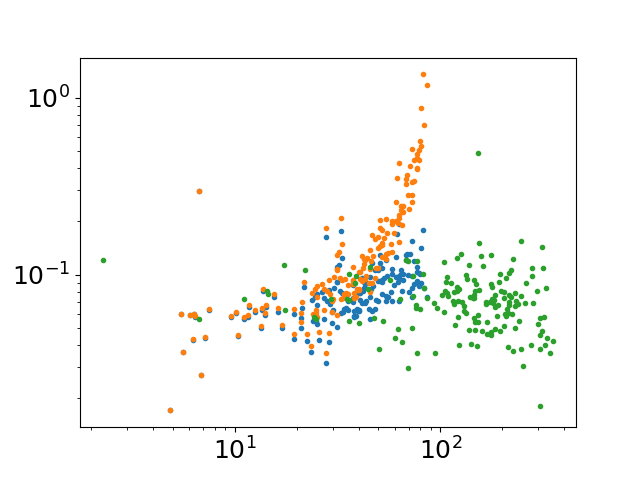

<IPython.core.display.Javascript object>


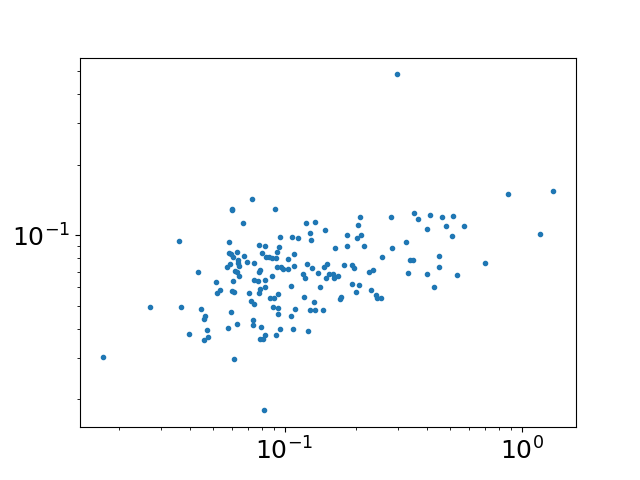

<IPython.core.display.Javascript object>


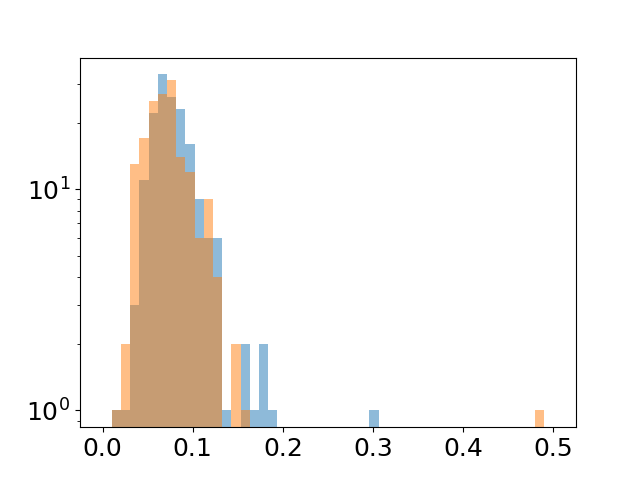

0.0821471222849
0.0757092698195


In [87]:
plt.figure()
plt.plot(_dec,_ra_std*np.cos(np.deg2rad(_dec)),".")
plt.plot(_dec,_ra_std,".")
plt.plot(_ra,_dec_std,".")
plt.xscale("log")
plt.yscale("log")

plt.figure()
plt.plot(_ra_std,_dec_std, ".")
plt.xscale("log")
plt.yscale("log")

plt.figure()
plt.hist(_ra_std*np.cos(np.deg2rad(_dec)), bins=np.linspace(0,0.5,50), log=True, alpha=0.5)
print np.mean(_ra_std*np.cos(np.deg2rad(_dec)))
plt.hist(_dec_std, bins=np.linspace(0,0.5,50), log=True, alpha=0.5)
print np.mean(_dec_std)